# Análise de Gráficos de Recorrência de Aparelhos da base REDD
---

Inpeção de aspectos visuais e estruturais de RPs.

# Ambiente

In [1]:
import os, sys, pickle
import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 10)
%matplotlib inline
from matplotlib.image import imsave
from PIL import Image

from nilmtk.dataset_converters import convert_redd

from nilmtk import DataSet
from nilmtk.utils import print_dict

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings(action="ignore")

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pyts.image import RecurrencePlot

from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computing_type import ComputingType
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Coleta e limpeza dos dados

In [2]:
dataset_path = "datasets/REDD/low_freq"

windows_data_path = os.path.join(dataset_path, "../../phd")
if not os.path.isdir(windows_data_path):
    os.makedirs(windows_data_path)

dataset_file = "datasets/REDD/redd.h5"
if not os.path.isfile(dataset_file):
    convert_redd(dataset_path, dataset_file)
    
sample_rate = 3

In [3]:
redd = DataSet(dataset_file)
print_dict(redd.metadata)

In [4]:
house_3 = redd.buildings[3]
print(house_3.elec)

MeterGroup(meters=
  ElecMeter(instance=1, building=3, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=3, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=3, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=4, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=5, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=3, dataset='REDD', appliances=[Appliance(type='CE appliance', instance=1)])
  ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=3, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])
  ElecMeter(instance=9, building=3, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=10, building=3, dataset='REDD', appliances=[Appliance(ty

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


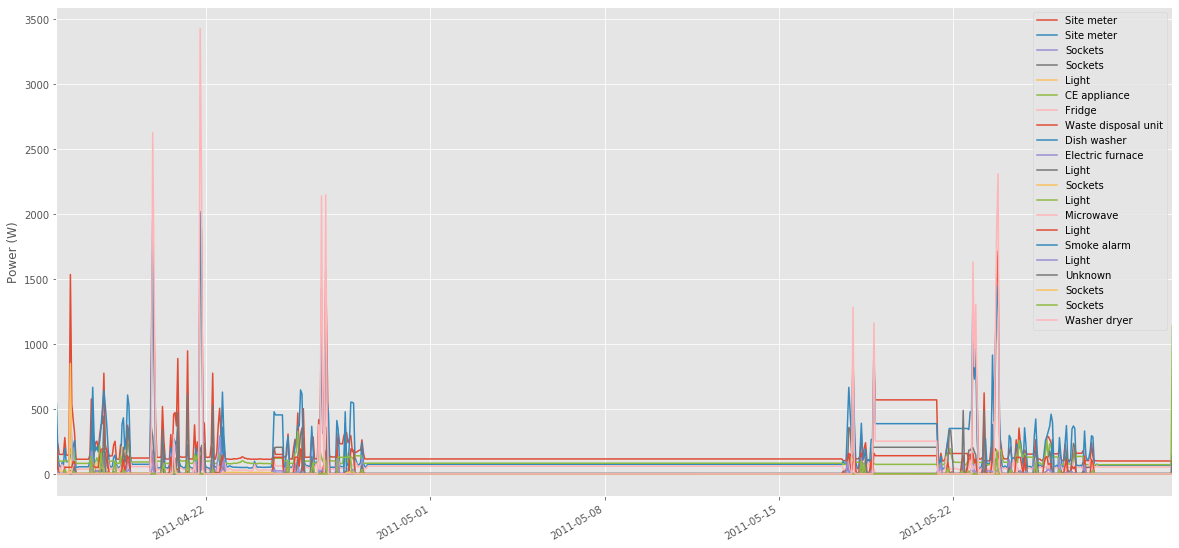

In [5]:
fig = plt.figure(figsize=(20, 10))
house_3.elec.plot();

In [6]:
# Amostras de Originais de Mains
house_3.elec.mains().power_series_all_data().head()

Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')      ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


2011-04-16 01:11:27-04:00    757.089966
2011-04-16 01:11:28-04:00    758.890015
2011-04-16 01:11:29-04:00    758.889954
2011-04-16 01:11:30-04:00    758.640015
2011-04-16 01:11:31-04:00    756.640015
Name: (power, apparent), dtype: float32

In [7]:
house_3.elec[1].power_series_all_data(sample_period=3).shape

(1290170,)

In [8]:
# Amostras de Originais de Aplpiance 3
house_3.elec[3].power_series_all_data().head()

2011-04-16 01:11:30-04:00    2.0
2011-04-16 01:11:33-04:00    1.0
2011-04-16 01:11:36-04:00    1.0
2011-04-16 01:11:40-04:00    2.0
2011-04-16 01:11:43-04:00    1.0
Name: (power, active), dtype: float32

In [9]:
house_3.elec[3].power_series_all_data(sample_period=3).shape

(1290163,)

**CONCLUSÃO PARCIAL:** É possível observar a diferenca de frequencias (mains e appliances, 1 e 3 segundos, respectivamente)

In [10]:
# Forçando taxa de 3 segundos para Mains
house_3.elec[1].power_series_all_data(sample_period=3).head()

2011-04-16 01:11:27-04:00    180.850006
2011-04-16 01:11:30-04:00    180.823334
2011-04-16 01:11:33-04:00    181.839996
2011-04-16 01:11:36-04:00    180.976669
2011-04-16 01:11:39-04:00    180.643341
Name: (power, apparent), dtype: float32

In [11]:
house_3.elec[1].power_series_all_data(sample_period=3).shape

(1290170,)

**CONCLUSÃO PARCIAL**: é possível normalizar as frequências, através do parâmetro `sample_period=SECOND_RATE`. Neste estudo, iremos `fixar esta taxa em 3 segundos`, tanto para as correntes princiais (medição geral - mains 1 e 2) quanto para os aparelhos.

Agora iremos verificar o intervalo de dados medidos, a fim de saber em quais momentos se iniciam e terminam os registros, tanto para `mains` quanto para os `appliances`.

In [12]:
# Mains
print("Mains head: ")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).head())
# Appliance 4
print("Appliance head: ")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).head())

print("- "*33, "\n")
print("Mains tail:")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).tail())

print("Appliance tail:")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).tail())

Mains head: 


2011-04-16 01:11:27-04:00    180.850006
2011-04-16 01:11:30-04:00    180.823334
2011-04-16 01:11:33-04:00    181.839996
2011-04-16 01:11:36-04:00    180.976669
2011-04-16 01:11:39-04:00    180.643341
Name: (power, apparent), dtype: float32

Appliance head: 


2011-04-16 01:11:30-04:00    0.0
2011-04-16 01:11:33-04:00    0.0
2011-04-16 01:11:36-04:00    0.0
2011-04-16 01:11:39-04:00    0.0
2011-04-16 01:11:42-04:00    0.0
Name: (power, active), dtype: float32

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Mains tail:


2011-05-30 20:19:42-04:00    15.46
2011-05-30 20:19:45-04:00    15.43
2011-05-30 20:19:48-04:00    15.44
2011-05-30 20:19:51-04:00    15.47
2011-05-30 20:19:54-04:00    15.46
Name: (power, apparent), dtype: float32

Appliance tail:


2011-05-30 20:19:24-04:00    1.0
2011-05-30 20:19:27-04:00    1.0
2011-05-30 20:19:30-04:00    1.0
2011-05-30 20:19:33-04:00    1.0
2011-05-30 20:19:36-04:00    1.0
Name: (power, active), dtype: float32

**IMPORTANTE:** É possível observar algumas inconsitências quanto ao intervalo:

    1. O primeiro registro de  `mains` é anterior ao primeiro registro do `appliance;
    2. O último registro de `appliance` é anterior ao último de `mains`.
    
Neste caso, iremos deimiltar o início e o fim das medições com base no primeiro e último *timestamp* de `appliances`, sendo estes `2011-04-16 01:11:30` e `2011-05-30 20:19:36`, respectivamente.

In [13]:
redd.set_window(
    #start='2011-04-16 01:11:30', 
    #end='2011-05-30 20:19:36'
    start='2011-04-16 05:11:30',
    end='2011-04-23 08:43:26'
)
house_3 = redd.buildings[3]

In [14]:
# Mains
print("Mains head: ")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).head())
# Appliance 4
print("Appliance head: ")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).head())

print("- "*33, "\n")
print("Mains tail:")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).tail())

print("Appliance tail:")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).tail())

Mains head: 


2011-04-16 05:11:30-04:00    144.820007
2011-04-16 05:11:33-04:00    146.666672
2011-04-16 05:11:36-04:00    146.009995
2011-04-16 05:11:39-04:00    144.856674
2011-04-16 05:11:42-04:00    144.550003
Name: (power, apparent), dtype: float32

Appliance head: 


2011-04-16 05:11:33-04:00    0.0
2011-04-16 05:11:36-04:00    0.0
2011-04-16 05:11:39-04:00    0.0
2011-04-16 05:11:42-04:00    0.0
2011-04-16 05:11:45-04:00    0.0
Name: (power, active), dtype: float32

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Mains tail:


2011-04-23 08:43:12-04:00    132.050003
2011-04-23 08:43:15-04:00    132.035004
2011-04-23 08:43:18-04:00    130.806671
2011-04-23 08:43:21-04:00    130.459991
2011-04-23 08:43:24-04:00    130.630005
Name: (power, apparent), dtype: float32

Appliance tail:


2011-04-23 08:43:09-04:00    0.0
2011-04-23 08:43:12-04:00    0.0
2011-04-23 08:43:15-04:00    0.0
2011-04-23 08:43:18-04:00    0.0
2011-04-23 08:43:21-04:00    0.0
Name: (power, active), dtype: float32

**CONCLUSÃO PARCIAL:** Neste momento, temos uma base de dados normalizada, seguindo os parâmetros:

    * Início das medições: 16/04/2011 às 01:11:30; 
    * Início das medições: 30/05/2011 às 20:19:36 (dependendo do tamanho da janela, definido posteriormente);
    * Taxa de amostragem: 3 segundos;
    * Residência: 3.

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


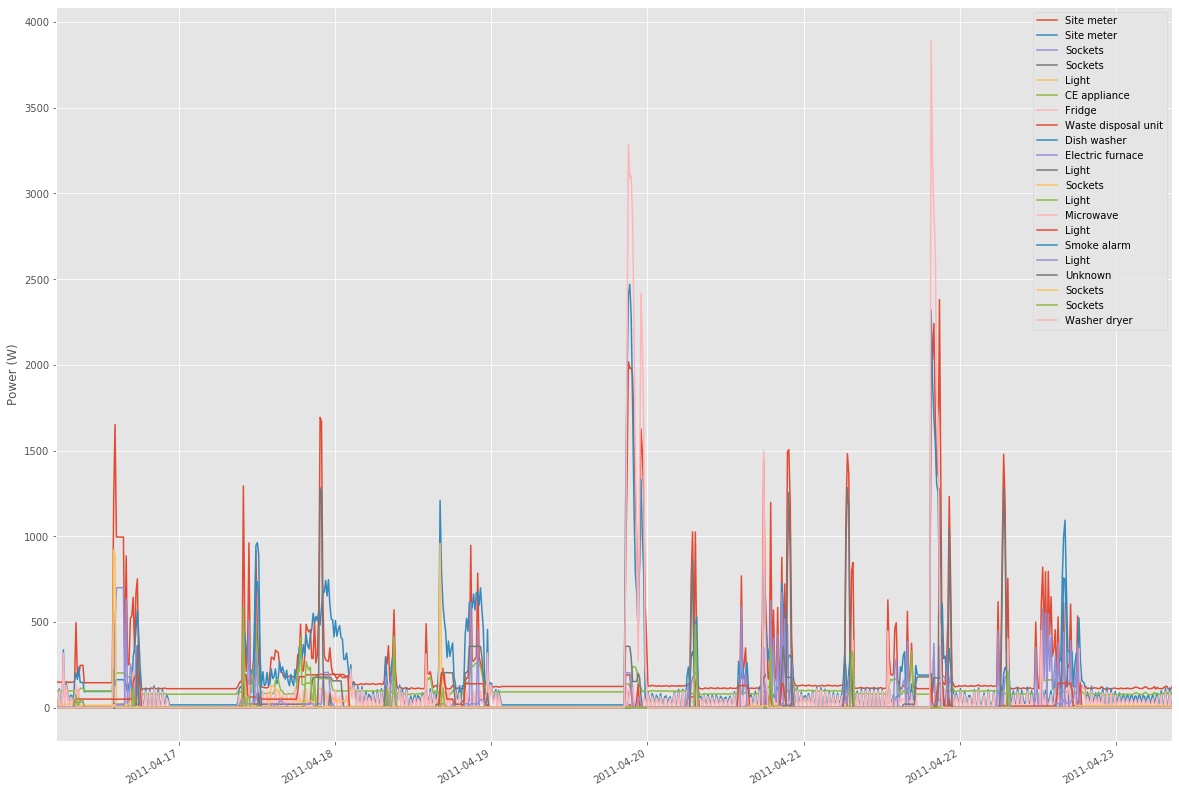

In [15]:
fig = plt.figure(figsize=(20, 15))
house_3.elec.plot();

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


<Figure size 1440x1080 with 0 Axes>

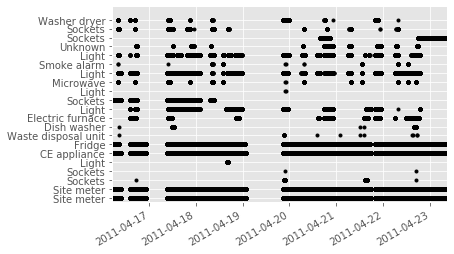

In [16]:
fig = plt.figure(figsize=(20, 15));
house_3.elec.plot_when_on();

In [17]:
top = house_3.elec.submeters().select_top_k(5, verbose=0)
print("\n")
print("Aparelhos com maiores consumo:")
print("------------------------------")
for e in top.meters:
    print( "#{} - {}".format( e.instance(), e.label() ))

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=13, building=3, dataset='REDD') ...    total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

Aparelhos com maiores consumo:
------------------------------
#6 - CE appliance
#(13, 14) - Washer dryer
#7 - Fridge
#10 - Electric furnace
#17 - Light


# Preparação dos dados 
---

Com os dados normalizados, é necessário dividir as medições em janelas com submedições.

In [35]:
# Window size (5 minutes, after converted to seconds and divided by sample rate), 
# resulting in unit split of each chunk (window)

window_length = int((1.5 * 60) / sample_rate)
# window_length = int((60 * 60) / sample_rate) # (minutes * 60) / sample rate = 1 hora de amostras
window_length

30

In [19]:
# Maximum size of series data (depending on window length)
series = house_3.elec.mains().power_series_all_data(sample_period=sample_rate)
series_limit = int(len(series.values)/window_length)*window_length
series_limit

Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')      ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


205830

In [20]:
start_timestamp = int(series.index[0].timestamp())
end_timestamp = int(series.index[series_limit].timestamp())

print("VALIDATED DATETIME INTERVAL:")
print()
print("- Initial datetime: {}".format( series.index[0].strftime(format="%d/%m/%Y %H:%M:%S") ) ) 
print("- Final datetime: {}".format( series.index[series_limit].strftime(format="%d/%m/%Y %H:%M:%S") )  )

VALIDATED DATETIME INTERVAL:

- Initial datetime: 16/04/2011 05:11:30
- Final datetime: 23/04/2011 08:43:00


In [21]:
# # Split and persist data...
# fig = plt.figure(figsize=(20,10))
# #for e in house_3.elec.all_meters():
# for e_i in range(1, len(house_3.elec.all_meters())+2):
    
#     e = house_3.elec[e_i]
#     data = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
    
#     print("Processing `{}` data ({} rows)...".format(e.label(), data.shape[0]))
    
#     # Split series in windows
#     data = data.reshape(-1, window_length)
#     # 
#     if e.label() == "Site meter":
        
#         print(data.shape)
#         np.save(
#             os.path.join(
#                 windows_data_path, 
#                 "{}-{}.npy".format(
#                     e.instance(),
#                     e.label().lower().replace(" ","_")
#                 )
#             ),
#             data
#         )
        
#     else:
#         # Appliance total energy in window
#         data = np.sum(data, axis=1)
#         np.save(
#             os.path.join(
#                 windows_data_path, 
#                 "{}-{}_total.npy".format(
#                     e.instance(),
#                     e.label().lower().replace(" ","_")
#                 )
#             ),
#             data
#         )
        
#         # ON/OFF status (1 if sum > 0 else 0)
#         data_binary = np.where(data > 0, 1, 0)
#         np.save(
#             os.path.join(
#                 windows_data_path, 
#                 "{}-{}_binary.npy".format(
#                     e.instance(),
#                     e.label().lower().replace(" ","_")
#                 )
#             ),
#             data_binary
#         )
#         plt.plot(data, label=e.label())

# plt.title("Window Power Consumption");
# plt.ylabel("Power");
# plt.legend();

**CONCLUSÃO:** Por fim, foram exportados 43.005 amostras, contemplando as janelas de 1 minuto e meio (90 segundos) de medição.

# EDA

## Funções Auxiliares

In [22]:
def scale(x, out_range=(-1, 1)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [23]:
def plot_serie(data, label):
    
    # Split series in windows
    #data = data.reshape(-1, window_length)
    fig, ax = plt.subplots(figsize=(20,5))
    
    # 
    if label != "Site meter":
        
        plt.plot(data, label=label)

        plt.title("Power Consumption - " + label);
        plt.ylabel("Power");
        plt.xlim(0, len(data)-1);

        plt.show();

## Gráficos de Recorrência por Aparelho - Apenas para Intervalos de Uso das Cargas
---

Através do módulo NILMTK, são extraídos, para cada aparelho, os intervalos de tempo em que estes estão em funcionamento. A idieia inicial é observar a curva de carga individual dos aparelhos considerenado apenas momentos em que estes são utilizados a fim de evidenciar as alterações de consumo energético durante sua operação. 

`Sockets` original size: 205837 dimensions


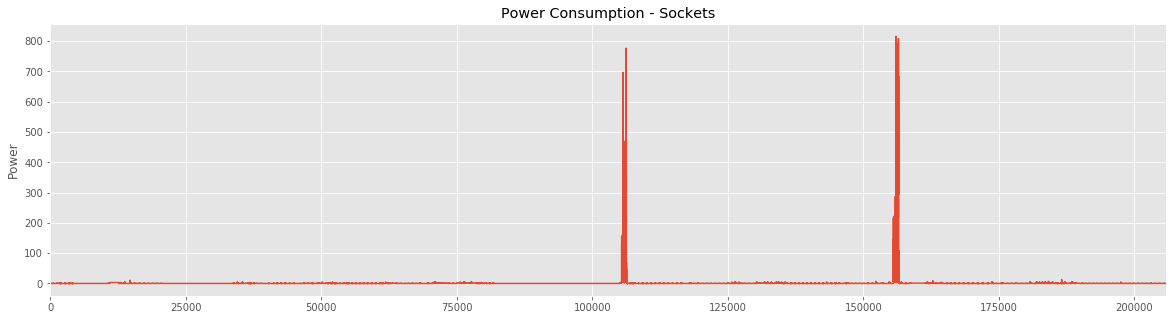

`Sockets` original size: 205837 dimensions
---> Sockets WARNING: Series dimension `WHEN ON` (3) is lower than RP time_delay (8)


`Light` original size: 205837 dimensions


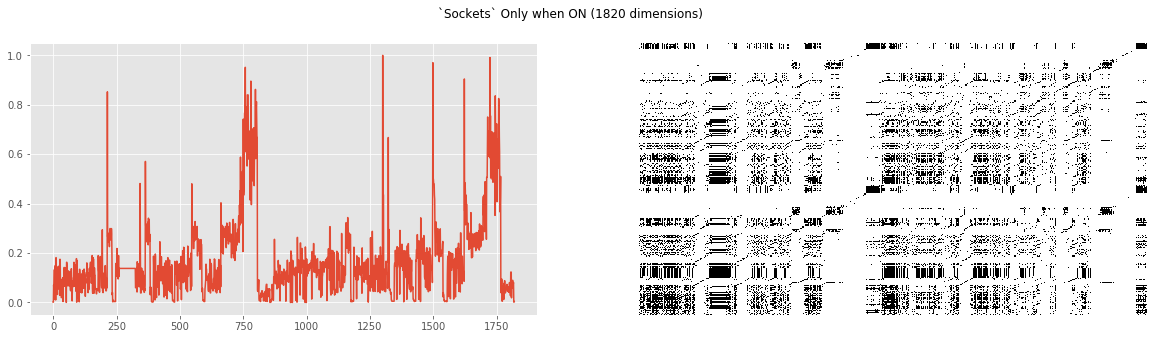

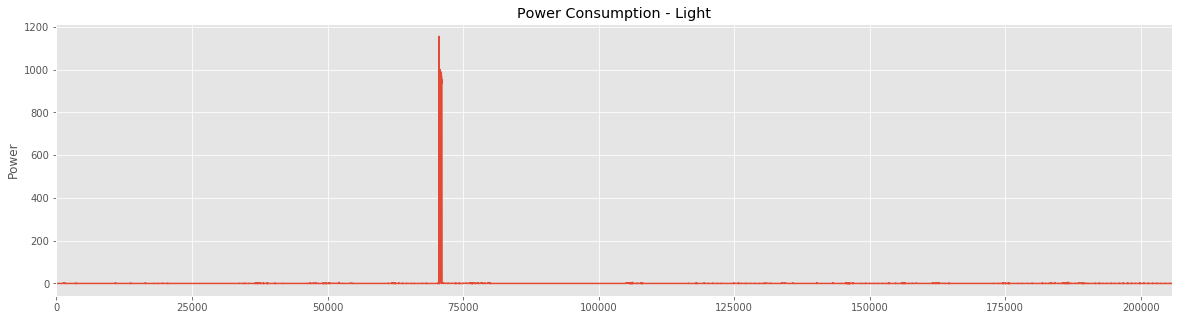

`CE appliance` original size: 205837 dimensions


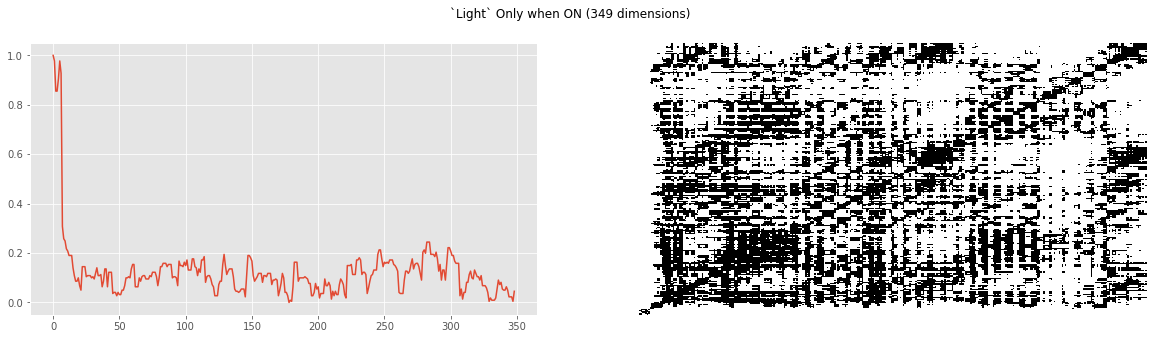

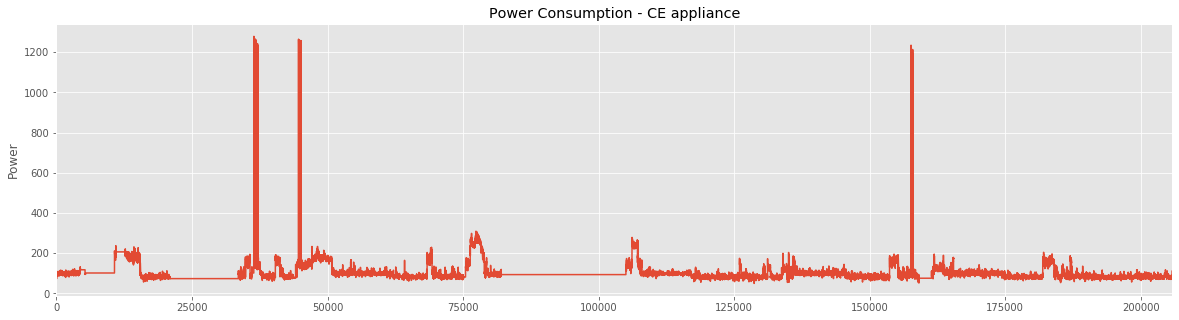

`Fridge` original size: 205837 dimensions


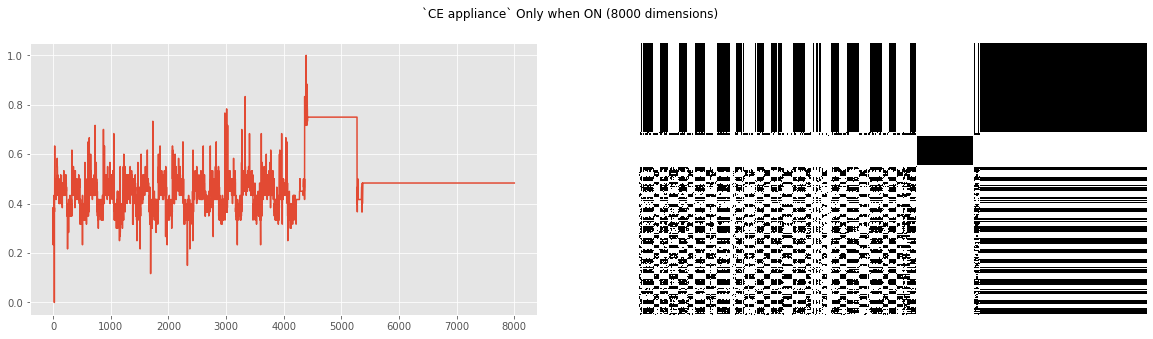

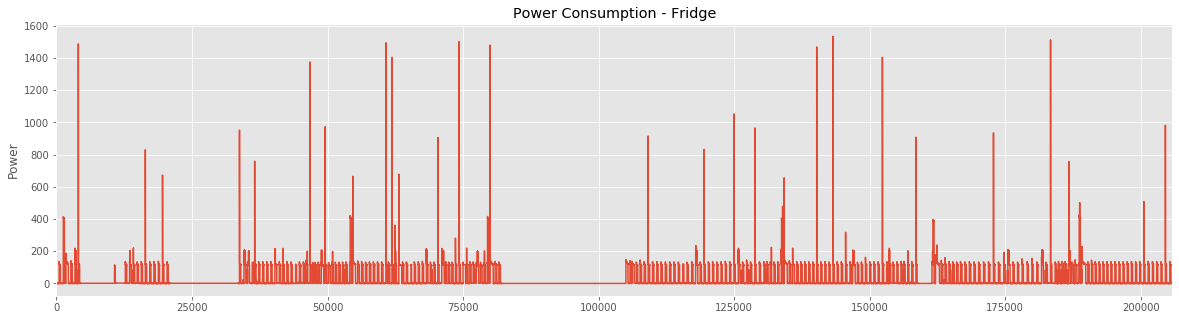

`Waste disposal unit` original size: 205837 dimensions


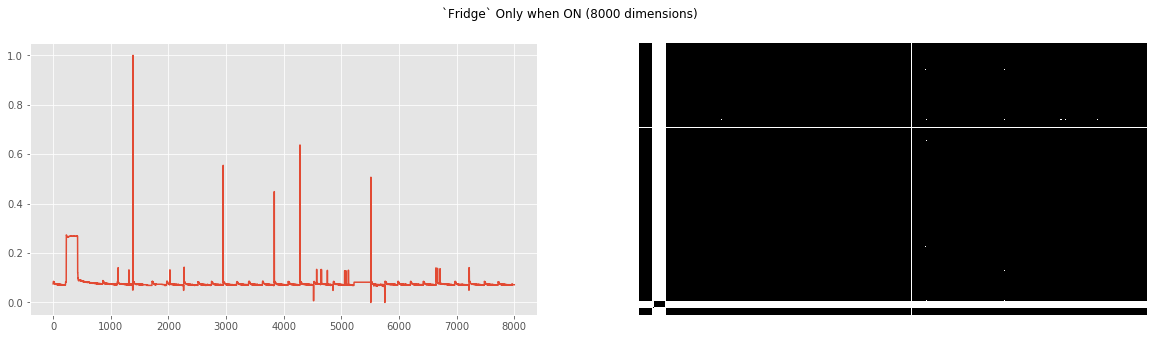

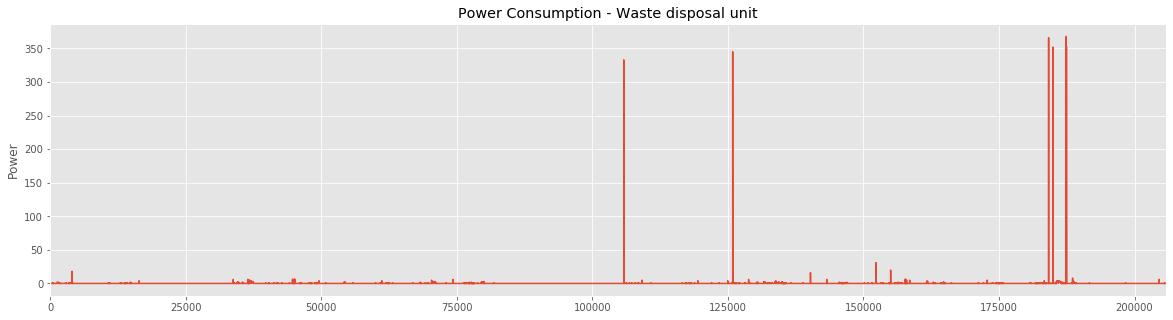

`Dish washer` original size: 205837 dimensions


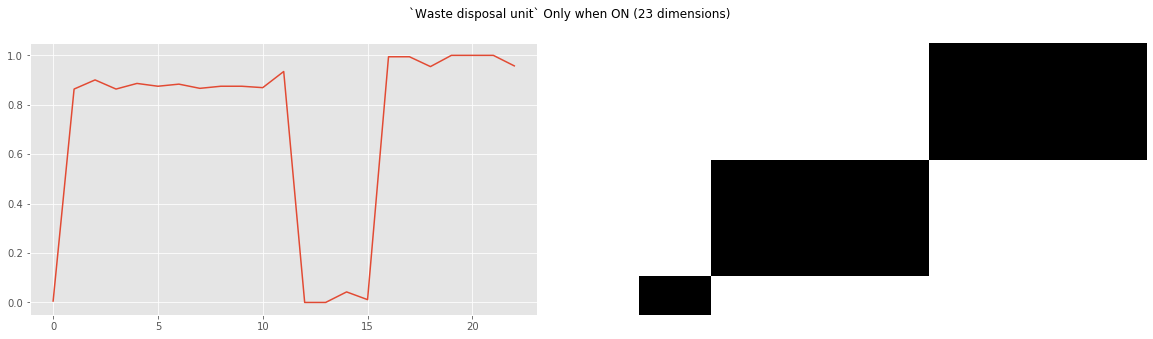

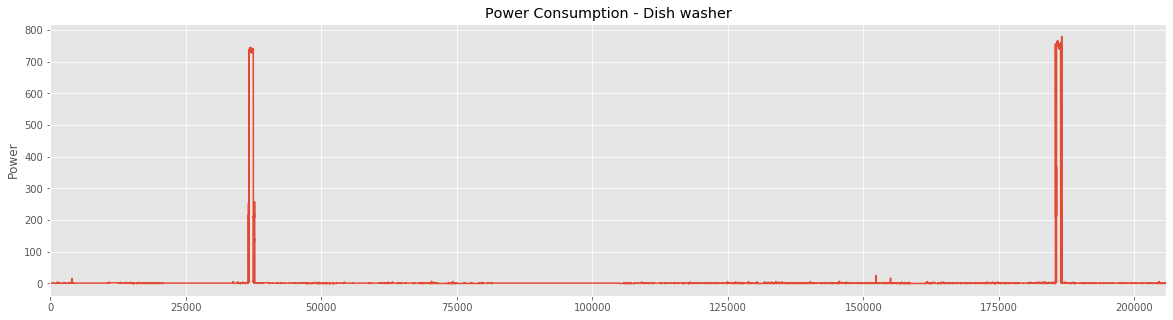

`Electric furnace` original size: 205837 dimensions


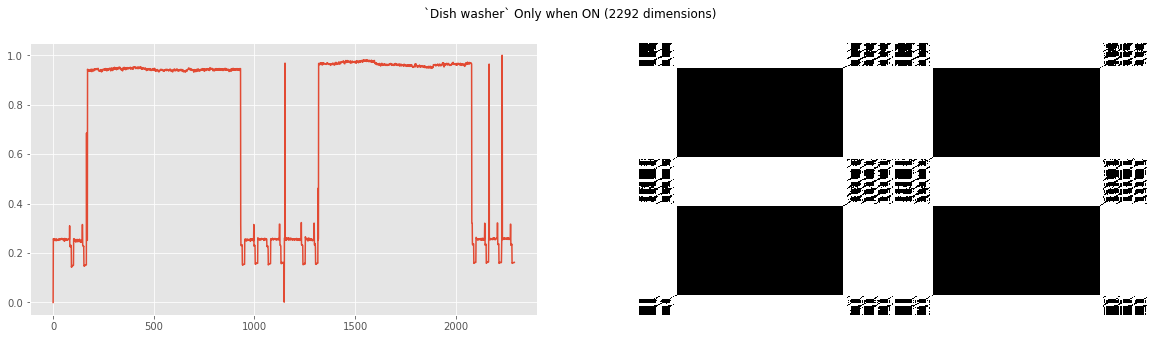

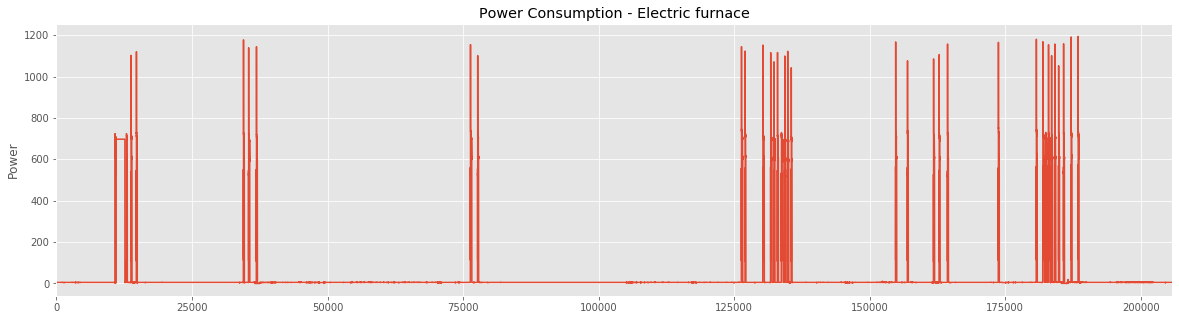

`Light` original size: 205837 dimensions


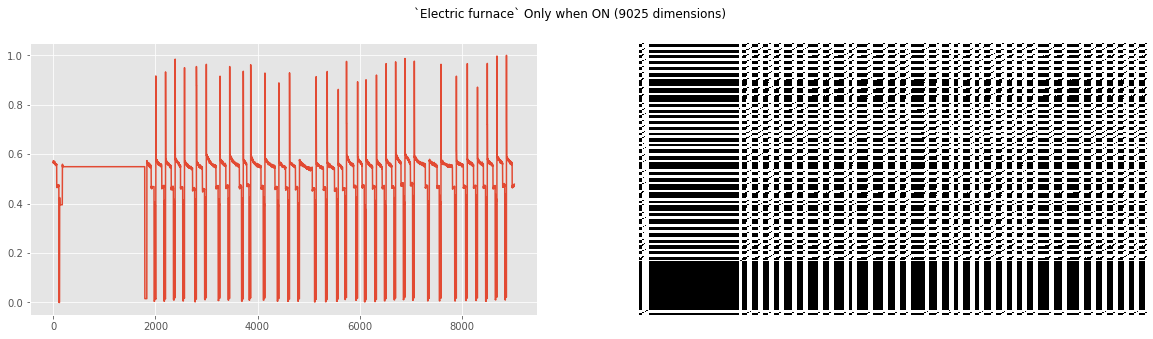

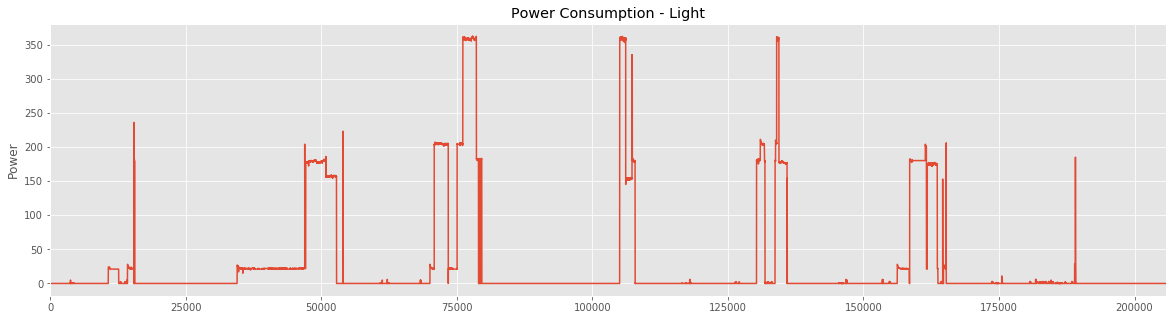

`Sockets` original size: 205837 dimensions


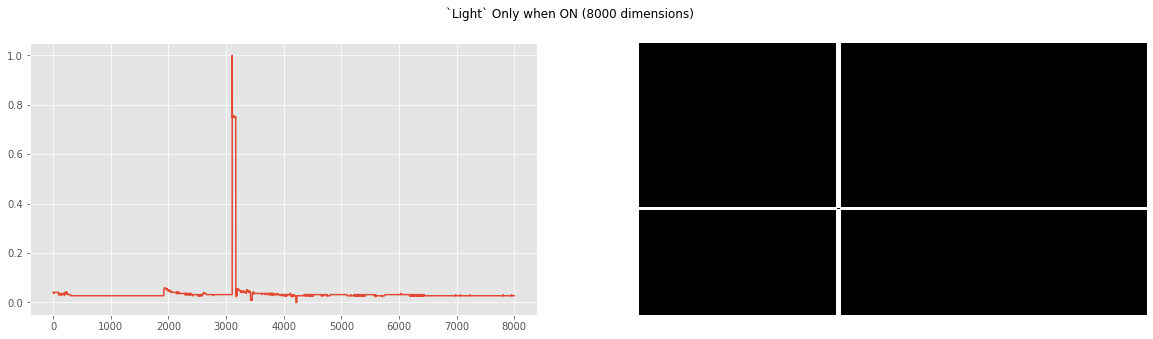

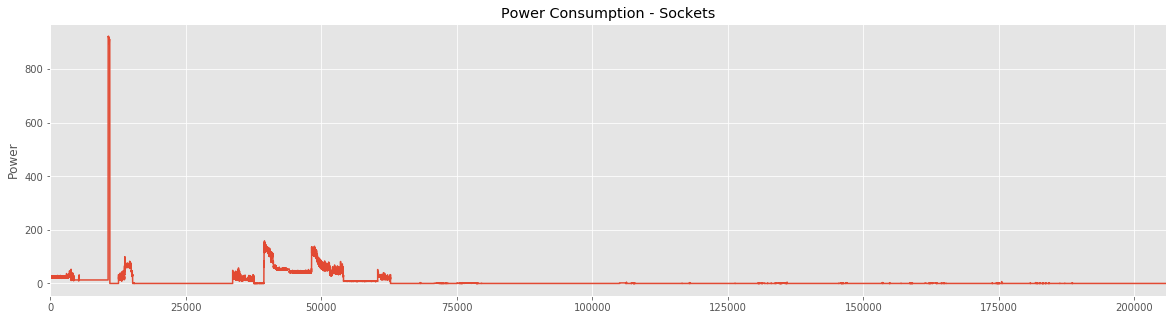

`Light` original size: 205837 dimensions
---> Light WARNING: Series dimension `WHEN ON` (4) is lower than RP time_delay (8)


`Microwave` original size: 205837 dimensions


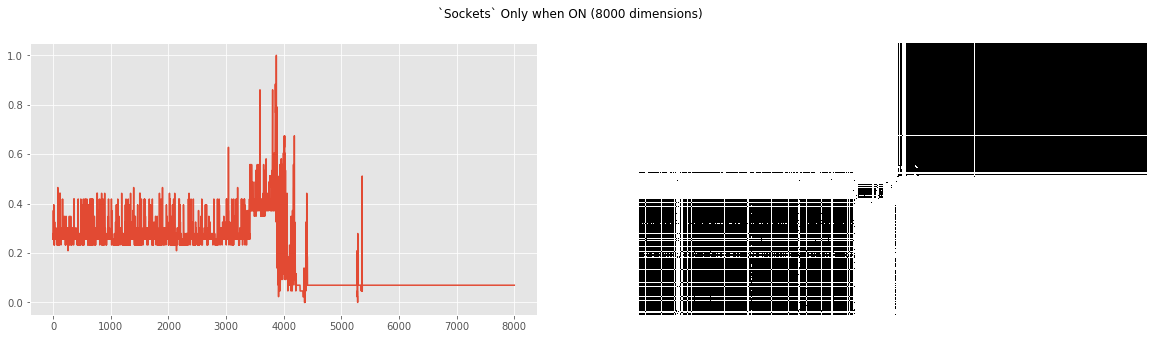

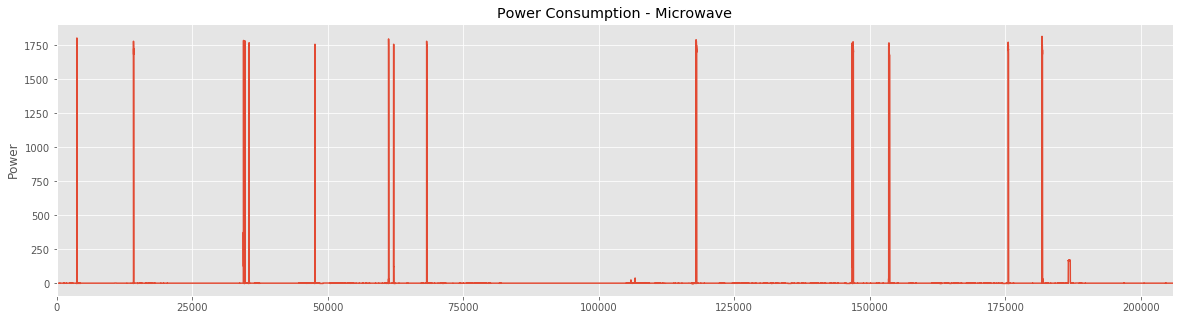

`Light` original size: 205837 dimensions


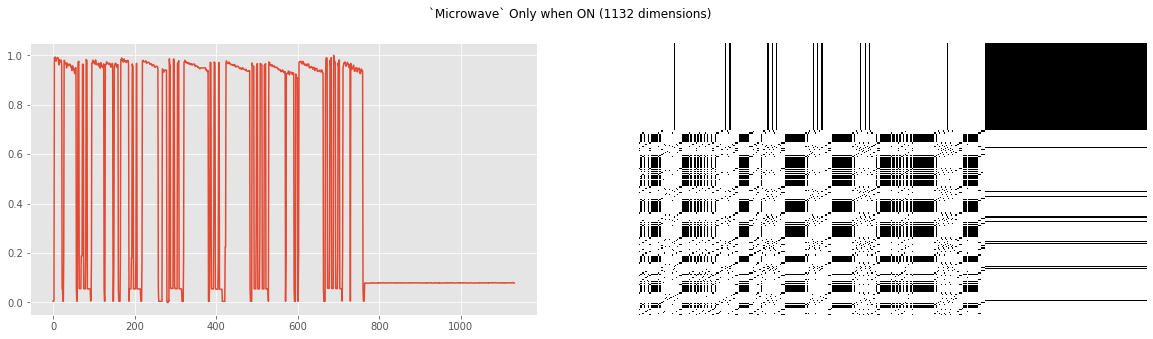

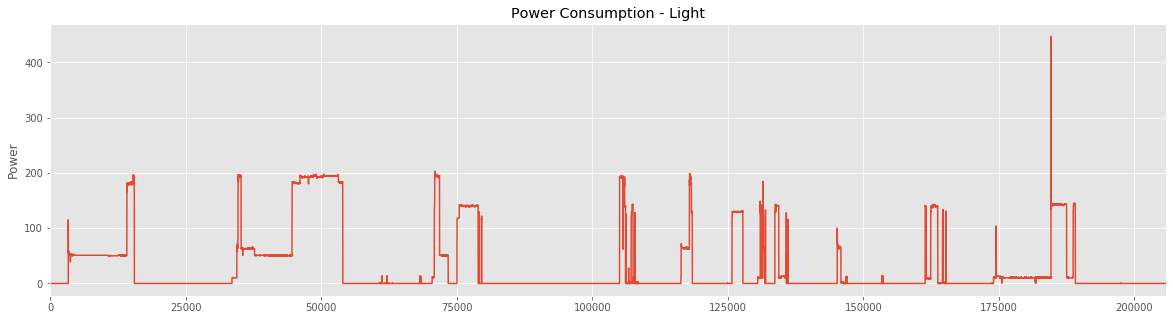

`Smoke alarm` original size: 205837 dimensions


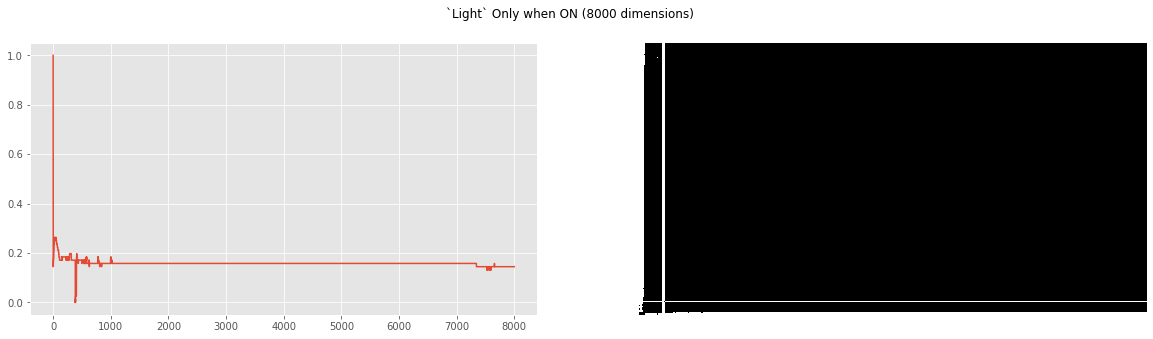

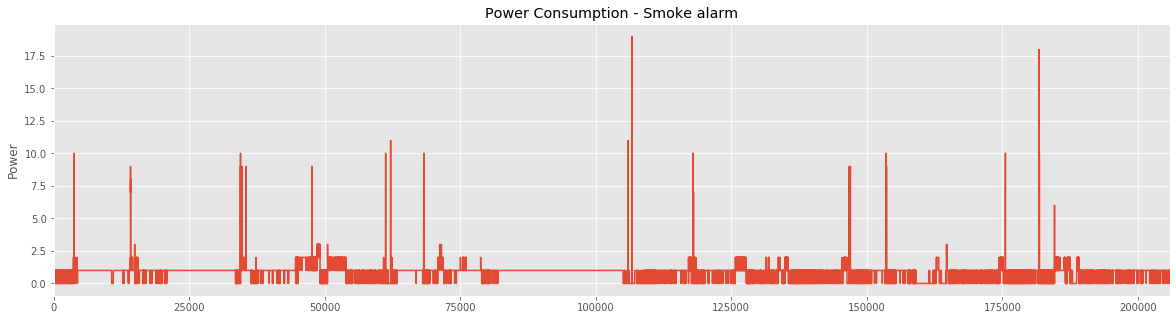

`Light` original size: 205837 dimensions


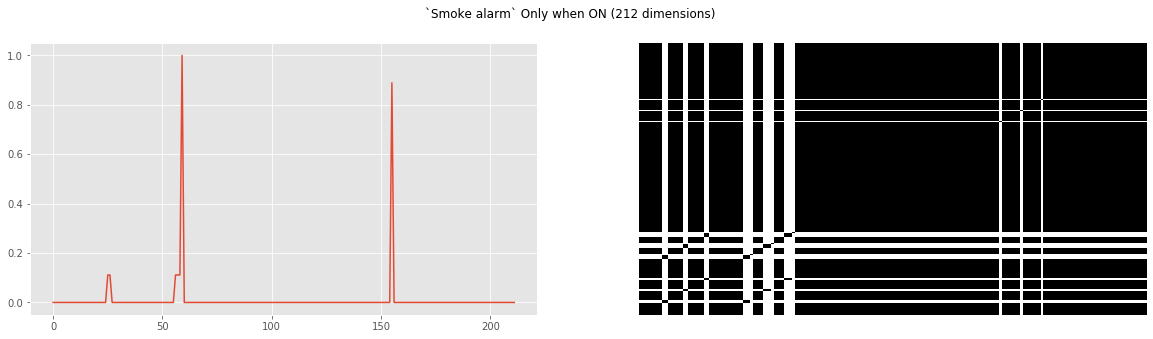

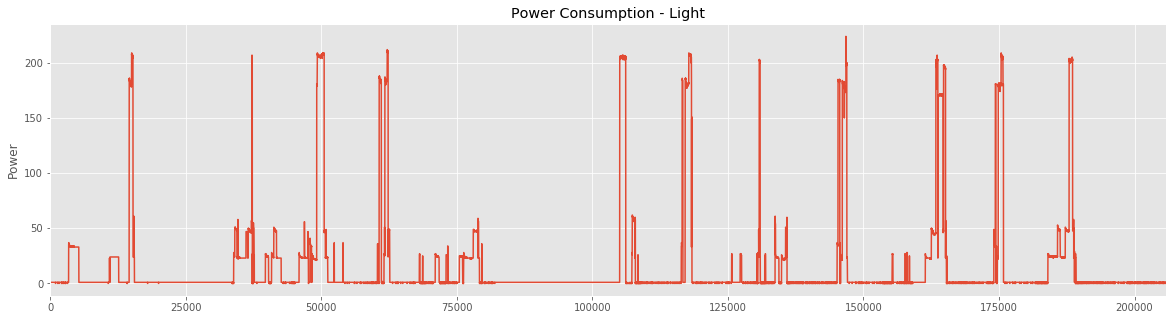

`Unknown` original size: 205837 dimensions


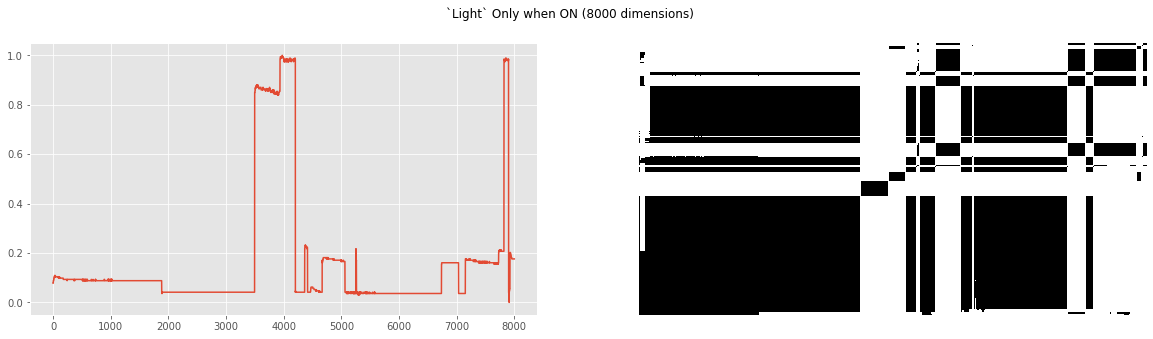

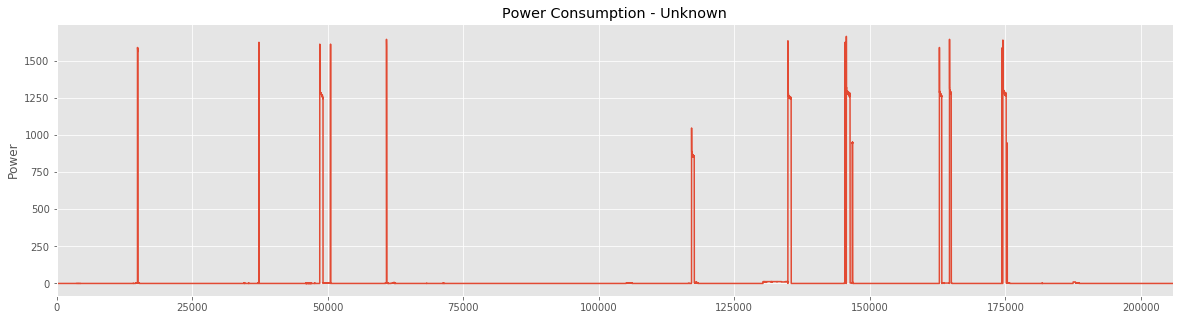

`Sockets` original size: 205837 dimensions


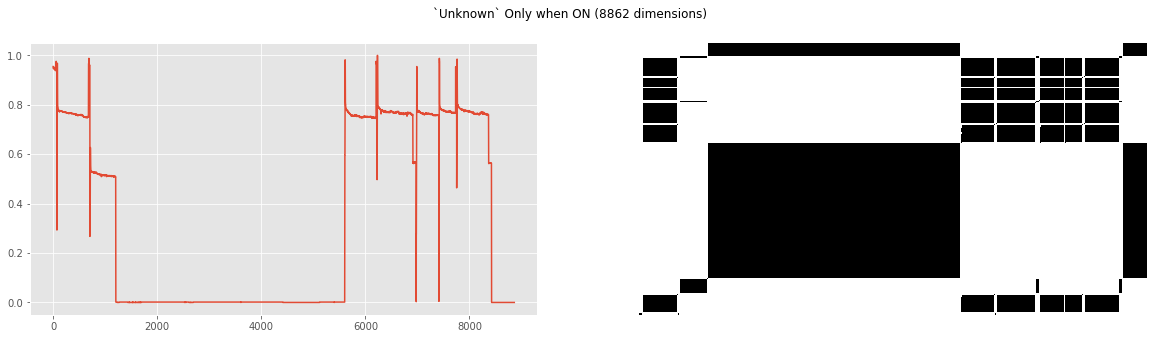

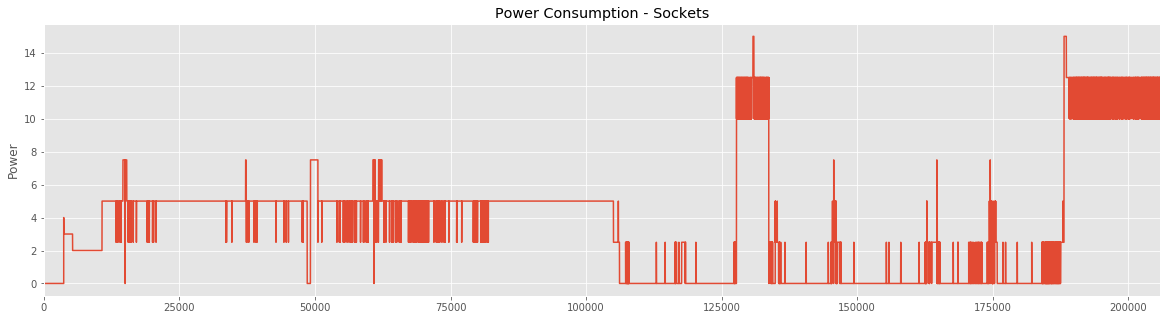

`Sockets` original size: 205837 dimensions


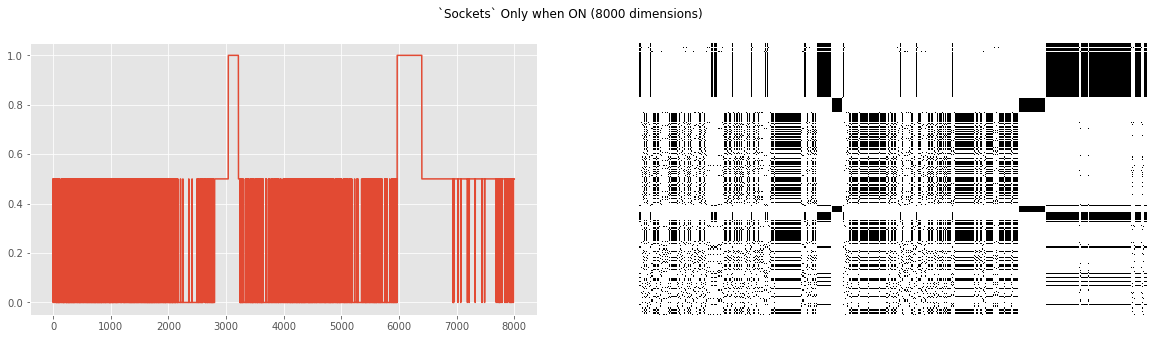

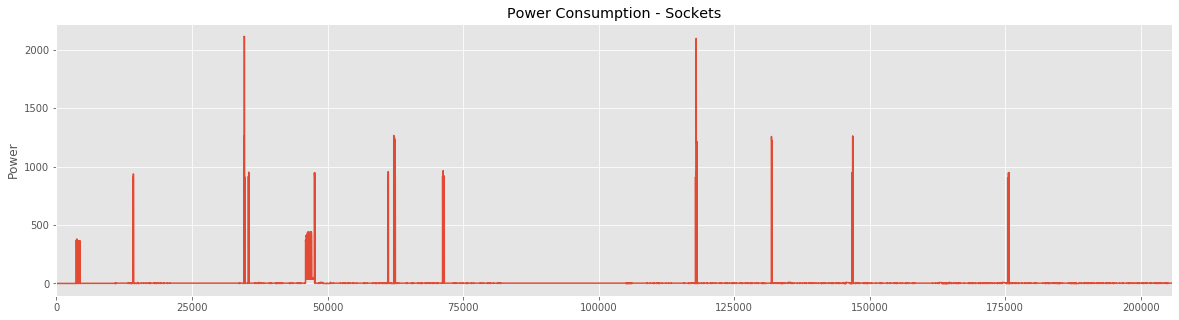

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
`Washer dryer` original size: 205839 dimensions
Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


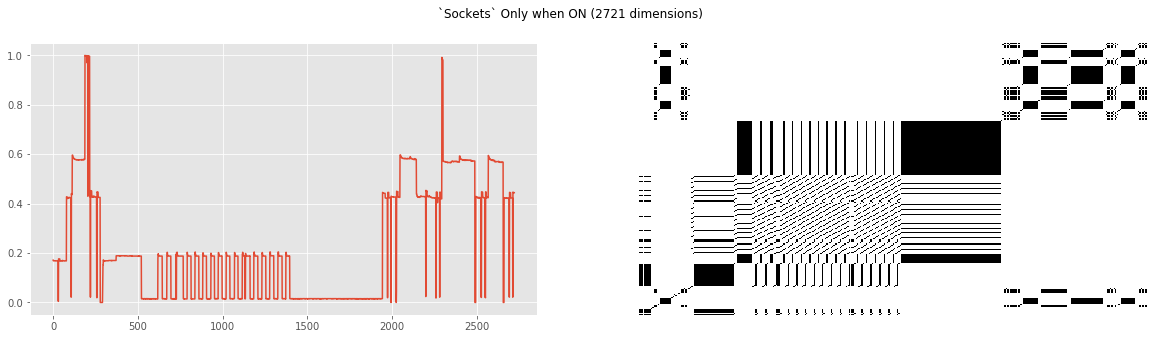

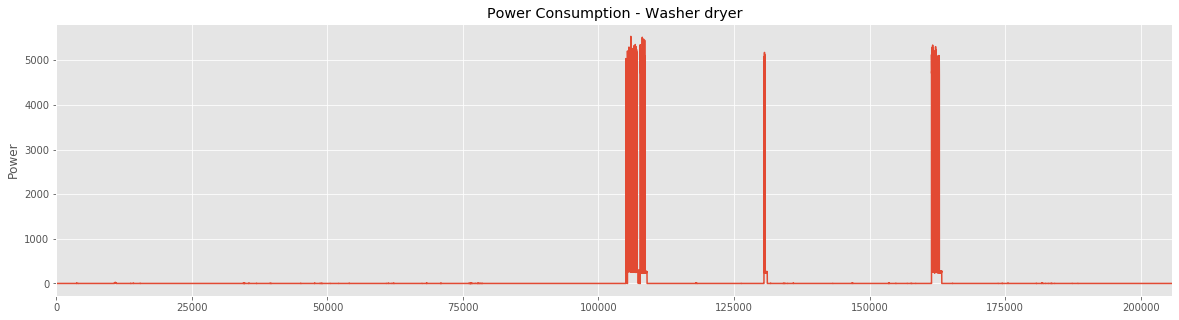

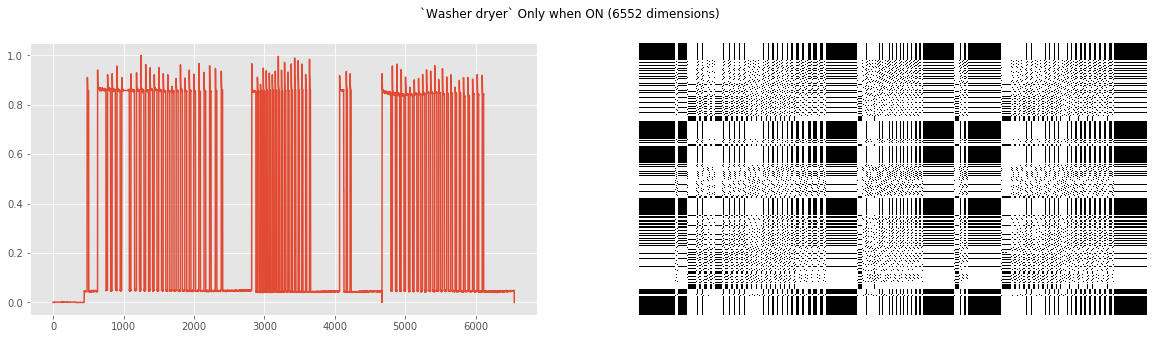

In [24]:
appliances_power = []
appliances_power_ON = []

rp_params = {
    "dimension": 3,
    "time_delay": 8,
    "threshold": 0.1
}
for e in house_3.elec.submeters().meters:

    power = e.power_series_all_data(sample_period=sample_rate)
    appliances_power.append(power)
    print("`{}` original size: {} dimensions".format(e.label(), power.shape[0]))

    when_on = next(e.when_on(sample_period=sample_rate))
    power_on = power[when_on == True].values
    power_on = np.where(np.isnan(power_on), 0, power_on)
    #print("`{}` WHEN ON size: {} dimensions".format(e.label(), power_on.shape[0]))
    #plot_serie(power_on, e.label()+" (when ON)")
    if len(power_on) >= rp_params["time_delay"]:
        if len(power_on) > 10000:#< int(series_limit/10): # >= Dimension RP AND <> max_len (not allocate memory error)
            power_on = power_on[:8000]

        # Original serie
        plot_serie(power.values, e.label())

        # Power ON
        power_on = scale(power_on, out_range=(0, 1)) if np.var(power_on) > 0 else power_on / max(power_on)#scale(power_on, out_range=(0, 1))
        appliances_power_ON.append(power_on)

        rp_image = RecurrencePlot(
                        dimension  = rp_params["dimension"],
                        time_delay = rp_params["time_delay"],
                        threshold  = rp_params["threshold"], # Limiar de recorrencia
                    ).fit_transform([power_on])[0]#(X.values)[0]

        fig = plt.figure(figsize=(20,5))
        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

        ax = fig.add_subplot(1, 2, 1)
        plt.plot(list(range(0, power_on.shape[0])), power_on)
        #plt.xlim(0, window_length-1)
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(rp_image, origin="lower", aspect="auto", cmap="binary")

        plt.axis('off')

        fig.suptitle("`{}` Only when ON ({} dimensions)".format(e.label(), power_on.shape[0]))
#         else:
#             print("---> {} WARNING: {}".format(e.label(), "High dimensionality `WHEN ON` ("+str(len(power_on))+")\n\n"))
    else:
        print("---> {} WARNING: {}".format(e.label(), "Series dimension `WHEN ON` ("+str(len(power_on))+") is lower than RP time_delay ("+str(rp_params["time_delay"])+")\n\n"))

In [25]:
PIK = os.path.join(windows_data_path, "appliances_power_ON_ipynb14.dat")
with open(PIK, "wb") as f:
    pickle.dump(appliances_power_ON, f)

**CONCLUSÃO**: Para os aparelhos em que foi possível gerar o RP, é possível observar que há discrepância mútua entre os gráficos de recorrências, denotando que a operação das carga são representadas de modo distinto através de RPs, o que indica um potencial interessante de segmentação de classes de aparelhos a fim de estabelecer um dataset factível para a classificação através de métodos de ML.

Por exemplo, comparando os RPs de operação das cargas `Smoke alarm` e `Wash Dryer` é possível observar um padrão mais estável de recorrência nesta primeira carga, diferentemente do padrão caótico da segunda, em compasso com a característica individual de utilização e funcionamento destas.

Em tempo, vale ressaltar que algumas cargas não foi possível gerar o RP devido a tamanho da série, que inviabilizou criar a matriz de recorrência diante dos recursos computacionais (memória) disponíveis. Como trabalho futuro, para tentar sanar este impeditivo, poderia ser explorada a possibilidade de gerar o RP para uma sub-amostra destas séries.

In [26]:
series_limit

205200

## Gráficos de Recorrência por Aparelho - Janelas de Tempo
---

Nesta etapa, diferentemente da anterior, a ideia é analisar todo o conjunto de dados registrado para cada aparelho. A fim de viabilizar tal análise, dado o grande espaço de monitoramento das cargas que resultou em séries de elevado comprimento - que inviabiliza o cálculo da matriz de recorrência, cada série temporal de cada carga foi dividida em "janelas" (chunks) de 60 minutos, as quais são gerados respectivos gráficos de recorrências.

Em tempo, vale ressaltar que após calcular os RPs para cada janela de carga aparelho, é escolhido uma amostra de imagem para cada carga a qual é exibida abaixo para a inspeção visual.

**References:**
    1. https://arxiv.org/pdf/1007.2215.pdf (RP Hyperparameter insights)
    2. https://arxiv.org/ftp/cond-mat/papers/0412/0412765.pdf (Phase-space reconstruction)
    3. https://acervodigital.ufpr.br/bitstream/handle/1884/17165/tese-everton.pdf?sequence=1&isAllowed=y
    4. http://pepsic.bvsalud.org/pdf/rbcdh/v29n1/pt_06.pdf
    5. http://propi.ifto.edu.br/ocs/index.php/connepi/vii/paper/viewFile/1457/2488

In [25]:
images_path = os.path.join(windows_data_path, "@@rp_analysis")
if not os.path.isdir(images_path):
    os.makedirs(images_path)

In [36]:
rp_params = {
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
    "dimension": 1,
    "time_delay": 1,
    "threshold": None
}

columns_rqa = [
    "Minimum diagonal line length (L_min)",
    "Minimum vertical line length (V_min)",
    "Minimum white vertical line length (W_min)",
    "Recurrence rate (RR)",
    "Determinism (DET)",
    "Average diagonal line length (L)",
    "Longest diagonal line length (L_max)",
    "Divergence (DIV)",
    "Entropy diagonal lines (L_entr)",
    "Laminarity (LAM)",
    "Trapping time (TT)",
    "Longest vertical line length (V_max)",
    "Entropy vertical lines (V_entr)",
    "Average white vertical line length (W)",
    "Longest white vertical line length (W_max)",
    "Longest white vertical line length inverse (W_div)",
    "Entropy white vertical lines (W_entr)",
    "Ratio determinism / recurrence rate (DET/RR)",
    "Ratio laminarity / determinism (LAM/DET)"
]

rqa_data = []


    
# Turn interactive plotting off
plt.ioff()
    
# for i, e in tqdm_notebook(enumerate(house_3.elec.submeters().meters)):
for e_i in tqdm_notebook(range(1, len(house_3.elec.all_meters())+2)):
    
    e = house_3.elec[e_i]
    
    appliance_images_path = os.path.join(images_path, str(e.instance())+"-"+e.label().lower().replace(" ","_"))
#     appliance_images_path = os.path.join("D:\\phd\\rp_analysis", str(e.instance())+"-"+e.label().lower().replace(" ","_"))
    if not os.path.isdir(appliance_images_path):
        os.makedirs(appliance_images_path) 
        
# currdir = os.path.join("D:\\", appliance_images_path.split("../")[-1])
# if not os.path.exists(currdir):
#     os.makedirs(currdir)
    
    power = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
    # data = np.array(power.values)
    # data = np.where(np.isnan(power), 0, power)
    data = power.reshape(-1, window_length)

    # Iterating over the windows, for random select a sample
    w = 0
    for window in tqdm(data):
        
        window = np.nan_to_num(window.tolist())
        window = scale(window, out_range=(0, 1)) if np.var(window) > 0 else window / max(window)#scale(window, out_range=(0, 1))
        
        if sum(window) > 0 and sum(window) < len(window) and np.isnan(sum(window)) == False:
            
#             image_path = os.path.join( appliance_images_path, "{}.png".format(w) )
            
            # Original Chunked serie
            if not os.path.isfile( os.path.join( appliance_images_path, "{}-chunk_series.png".format(w) ) ):
                
                # Original Serie
                fig = plt.figure(figsize=(20,10))
                fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
                plt.plot(list(range(0, window.shape[0])), window)
                plt.axis('off')
                plt.savefig(
                    os.path.join( appliance_images_path, "{}-chunk_series.png".format(w) ), 
                    bbox_inches='tight'
                )
                plt.close(fig)
            
            # RP embedding    
            if not os.path.isfile( os.path.join( appliance_images_path, "{}-rp.png".format(w) ) ):
                
                fig = plt.figure(figsize=(20,10))
                fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
                rp_image = RecurrencePlot(
                                dimension  = rp_params["dimension"],
                                time_delay = rp_params["time_delay"],
                                threshold  = rp_params["threshold"], # Limiar de recorrencia
                                percentage = rp_params["percentage"]
                            ).fit_transform([window])[0]#(X.values)[0]
                plt.imshow(rp_image, origin="lower", aspect="auto", cmap="binary")
                plt.axis('off')
                plt.savefig(
                    os.path.join( appliance_images_path, "{}-rp.png".format(w) ), 
                    bbox_inches='tight'
                )
                plt.close(fig)
            
            # Calculating RQA
            time_series = TimeSeries(window,
                         embedding_dimension=rp_params["dimension"],
                         time_delay=rp_params["time_delay"])
            settings = Settings(time_series,
                                computing_type=ComputingType.Classic,
                                neighbourhood=FixedRadius(rp_params["threshold"]),
                                similarity_measure=EuclideanMetric)
            computation = RQAComputation.create(settings, verbose=False)
            rqa_result = computation.run()
            
            
            rqa_data.append( ["{} - {}".format(e.instance(), e.label()), w] + list(rqa_result.to_array()) )

            w += 1


  1%|▊                                                                               | 69/6861 [00:09<15:01,  7.54it/s]

KeyboardInterrupt: 

In [ ]:
rp_params = {
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}

top_appliances=[
    {"id": 7, "label": "Fridge"},
    {"id": 9, "label": "Dish washer"},
    {"id": 13, "label": "Washer dryer"},
    {"id": 14, "label": "Washer dryer"},
    {"id": 16, "label": "Microwave"}
]

columns_rqa = [
    "Minimum diagonal line length (L_min)",
    "Minimum vertical line length (V_min)",
    "Minimum white vertical line length (W_min)",
    "Recurrence rate (RR)",
    "Determinism (DET)",
    "Average diagonal line length (L)",
    "Longest diagonal line length (L_max)",
    "Divergence (DIV)",
    "Entropy diagonal lines (L_entr)",
    "Laminarity (LAM)",
    "Trapping time (TT)",
    "Longest vertical line length (V_max)",
    "Entropy vertical lines (V_entr)",
    "Average white vertical line length (W)",
    "Longest white vertical line length (W_max)",
    "Longest white vertical line length inverse (W_div)",
    "Entropy white vertical lines (W_entr)",
    "Ratio determinism / recurrence rate (DET/RR)",
    "Ratio laminarity / determinism (LAM/DET)"
]

rqa_data = []
    
# Turn interactive plotting off
plt.ioff()
    
# for i, e in tqdm_notebook(enumerate(house_3.elec.submeters().meters)):
for e_i in tqdm_notebook(range(1, len(house_3.elec.all_meters())+2)):
    
    e = house_3.elec[e_i]
    
    appliance_images_path = os.path.join(images_path, str(e.instance())+"-"+e.label().lower().replace(" ","_"))
#     appliance_images_path = os.path.join("D:\\phd\\rp_analysis", str(e.instance())+"-"+e.label().lower().replace(" ","_"))
    if not os.path.isdir(appliance_images_path):
        os.makedirs(appliance_images_path) 
        
# currdir = os.path.join("D:\\", appliance_images_path.split("../")[-1])
# if not os.path.exists(currdir):
#     os.makedirs(currdir)
    
    power = np.array(e.power_series_all_data(sample_period=sample_rate).values[:series_limit])
    # data = np.array(power.values)
    # data = np.where(np.isnan(power), 0, power)
    data = power.reshape(-1, window_length)

    # Iterating over the windows, for random select a sample
    w = 0
    for window in tqdm_notebook(data):
        
        window = np.nan_to_num(window.tolist())
        window = scale(window, out_range=(0, 1)) if np.var(window) > 0 else window / max(window)#scale(window, out_range=(0, 1))
        
        if sum(window) > 0 and sum(window) < len(window) and np.isnan(sum(window)) == False:
            
#             image_path = os.path.join( appliance_images_path, "{}.png".format(w) )
            
            # Original Chunked serie
            if not os.path.isfile( os.path.join( appliance_images_path, "{}-chunk_series.png".format(w) ) ):
                
                # Original Serie
                fig = plt.figure(figsize=(20,10))
                fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
                plt.plot(list(range(0, window.shape[0])), window)
                plt.axis('off')
                plt.savefig(
                    os.path.join( appliance_images_path, "{}-chunk_series.png".format(w) ), 
                    bbox_inches='tight'
                )
                plt.close(fig)
            
            # RP embedding    
            if not os.path.isfile( os.path.join( appliance_images_path, "{}-rp.png".format(w) ) ):
                
                fig = plt.figure(figsize=(20,10))
                fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
                rp_image = RecurrencePlot(
                                dimension  = rp_params["dimension"],
                                time_delay = rp_params["time_delay"],
                                threshold  = rp_params["threshold"], # Limiar de recorrencia
                                percentage= rp_params["percentage"]
                            ).fit_transform([window])[0]#(X.values)[0]
                plt.imshow(rp_image, origin="lower", aspect="auto", cmap="binary")
                plt.axis('off')
                plt.savefig(
                    os.path.join( appliance_images_path, "{}-rp.png".format(w) ), 
                    bbox_inches='tight'
                )
                plt.close(fig)
            
            # Calculating RQA
            time_series = TimeSeries(window,
                         embedding_dimension=rp_params["dimension"],
                         time_delay=rp_params["time_delay"])
            settings = Settings(time_series,
                                computing_type=ComputingType.Classic,
                                neighbourhood=FixedRadius(rp_params["threshold"]),
                                similarity_measure=EuclideanMetric)
            computation = RQAComputation.create(settings, verbose=False)
            rqa_result = computation.run()
            
            
            rqa_data.append( ["{} - {}".format(e.instance(), e.label()), w] + list(rqa_result.to_array()) )

            w += 1

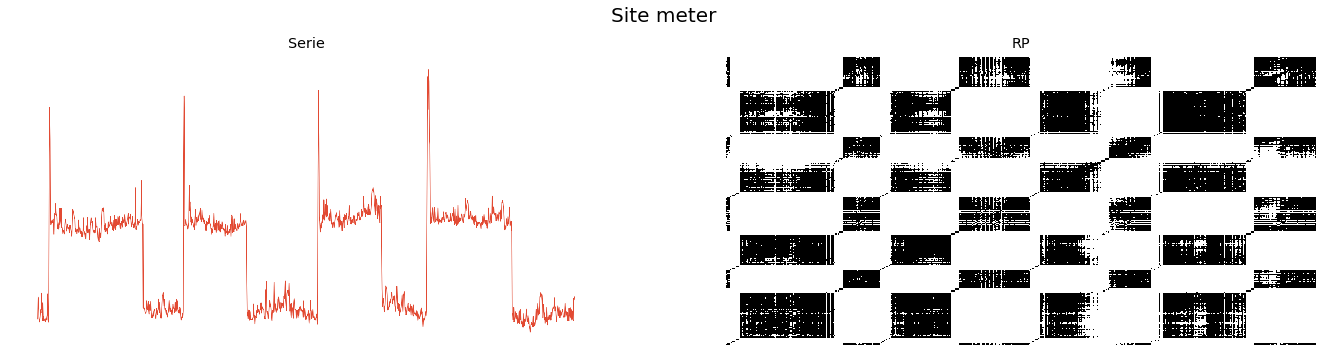

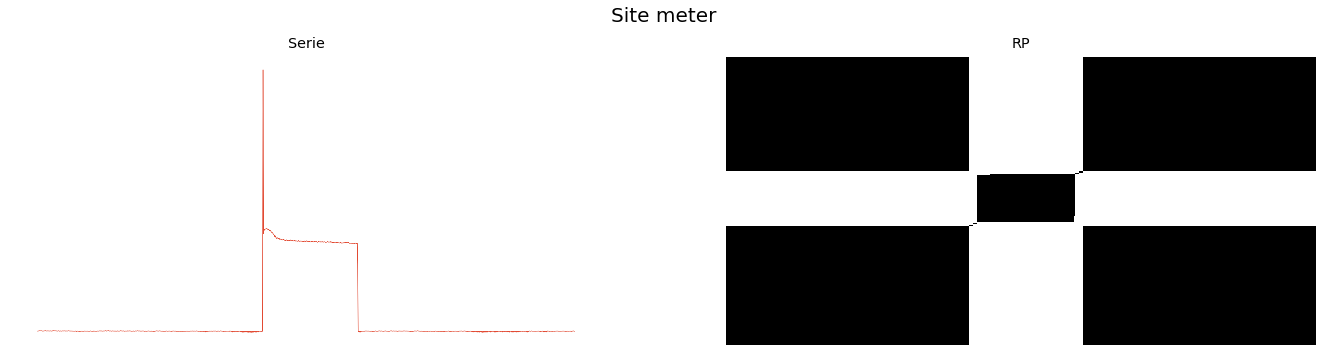

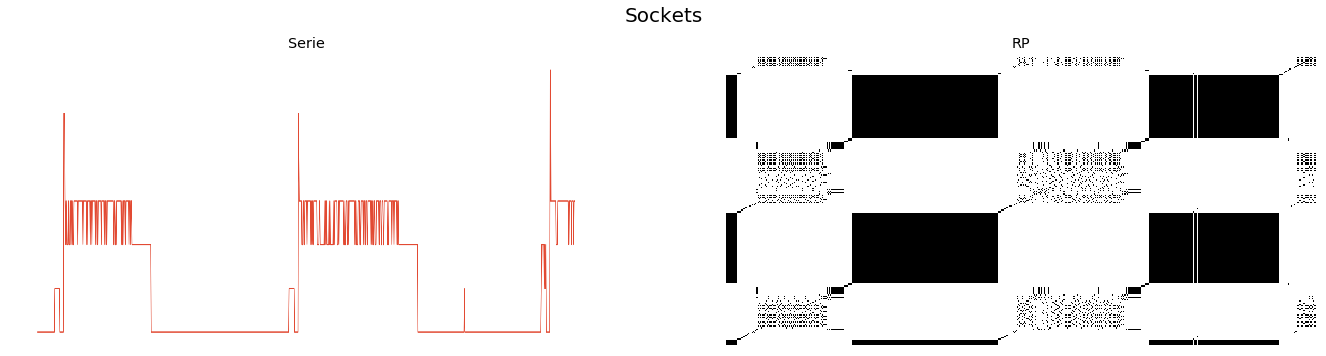

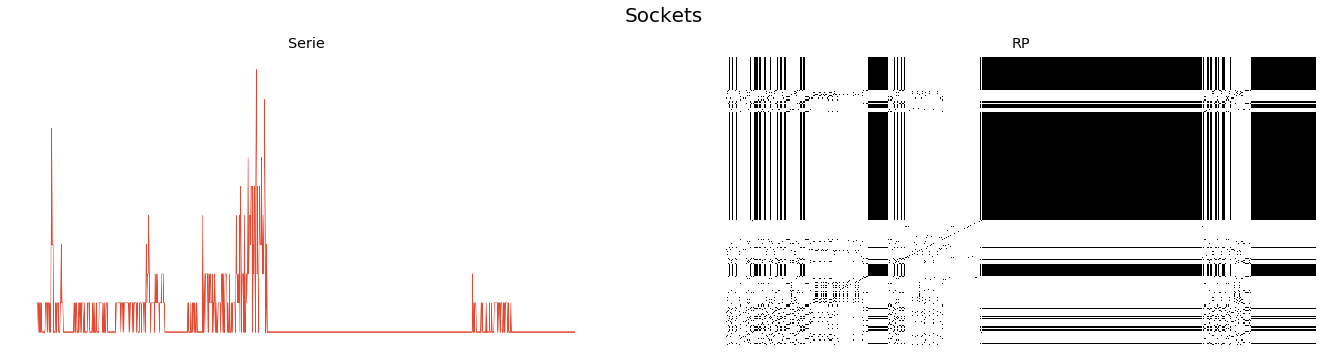

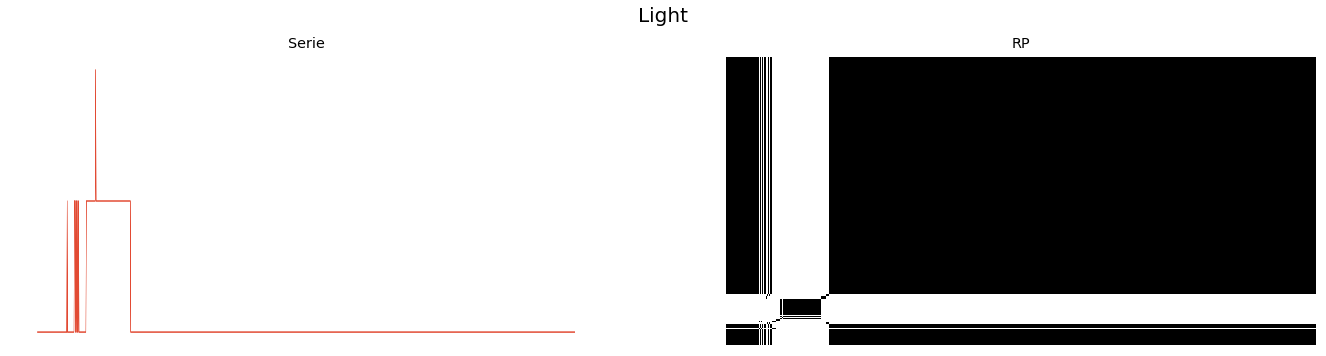

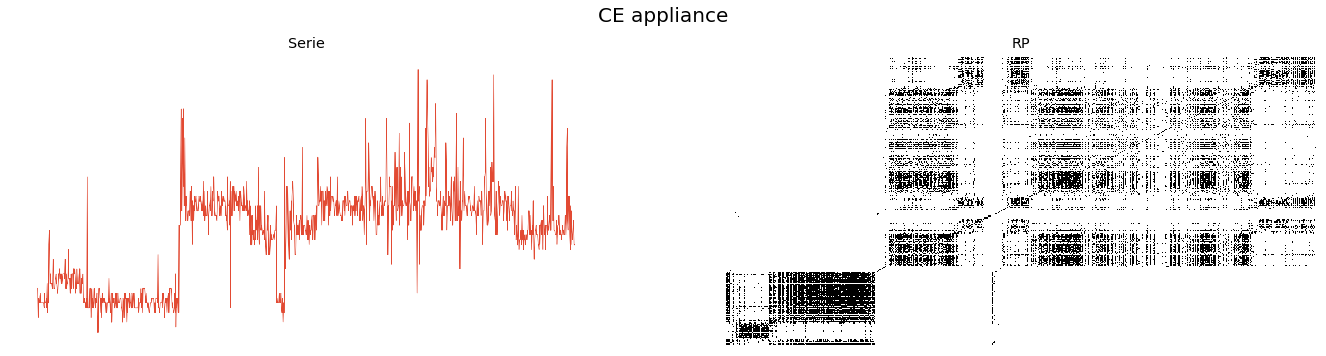

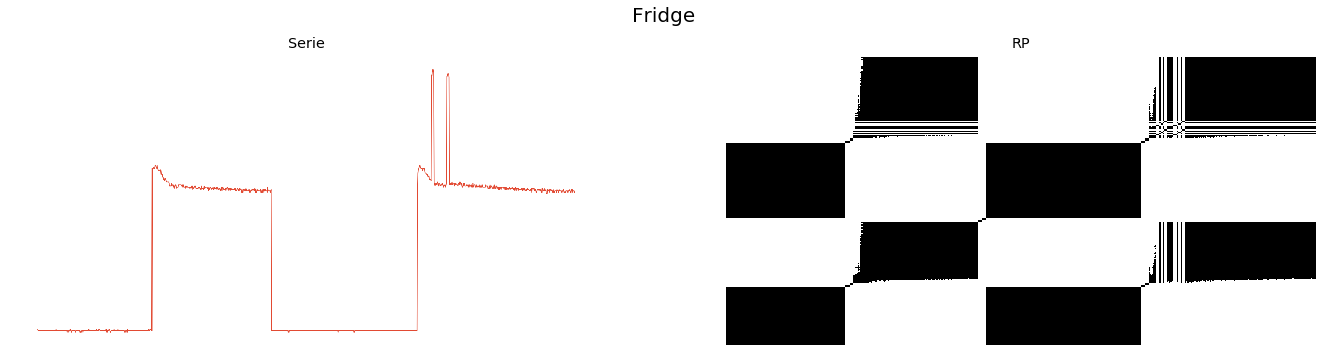

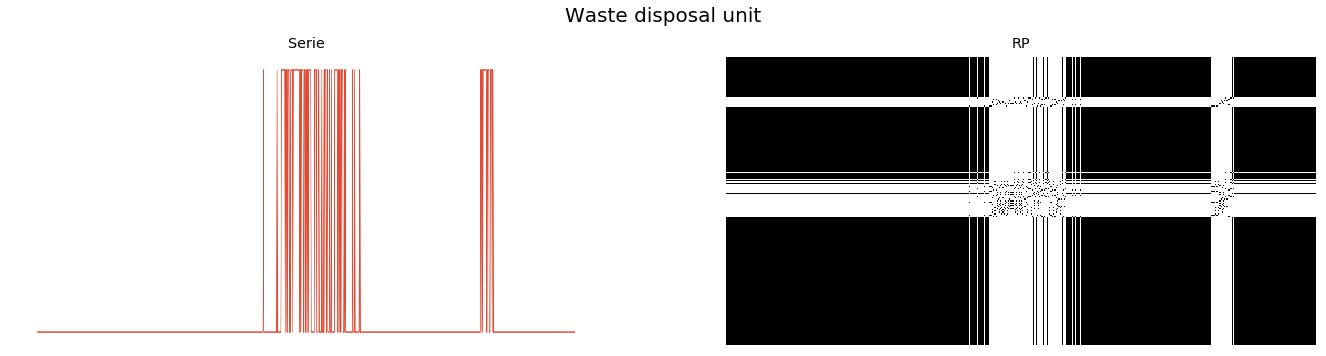

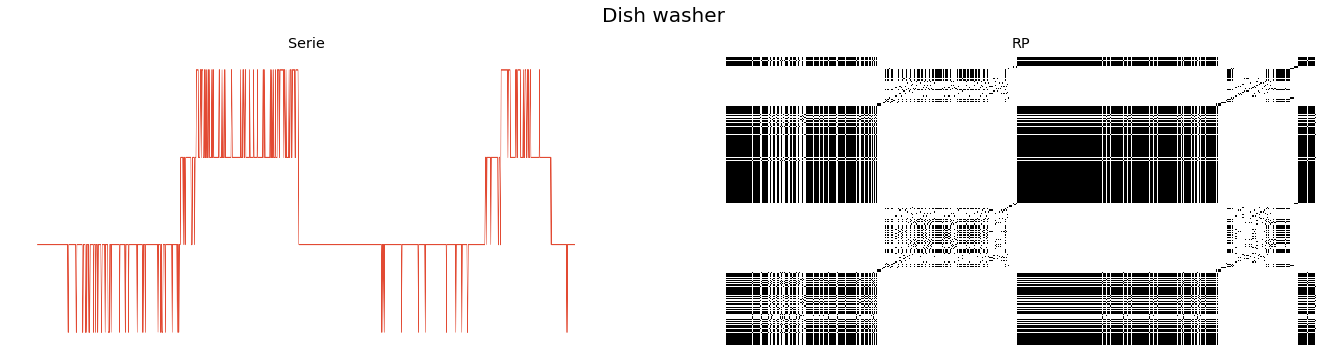

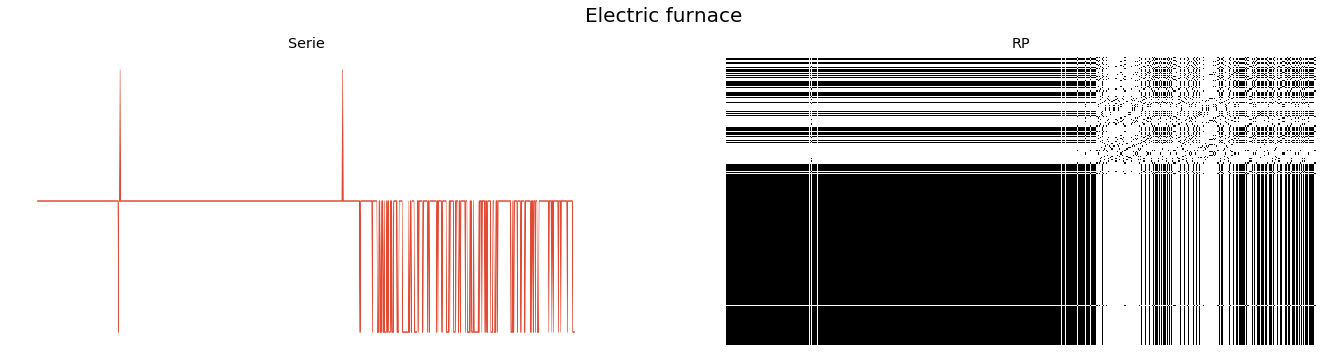

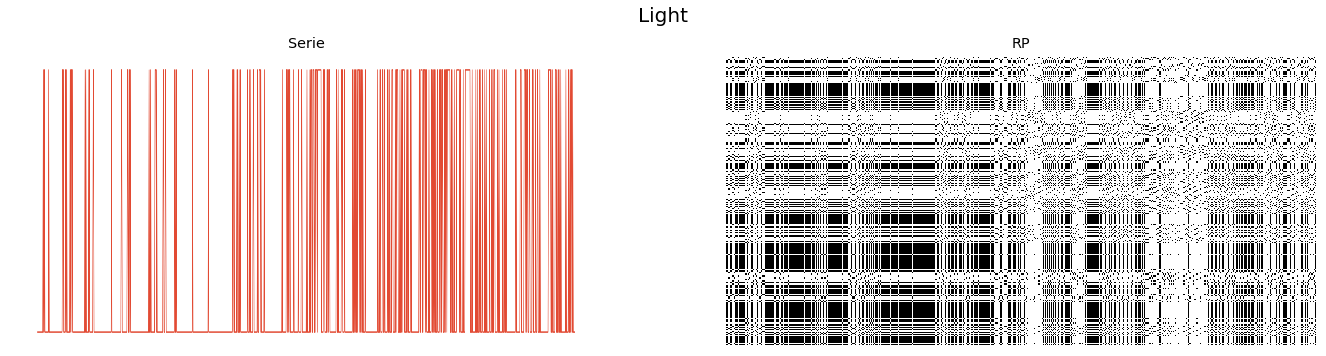

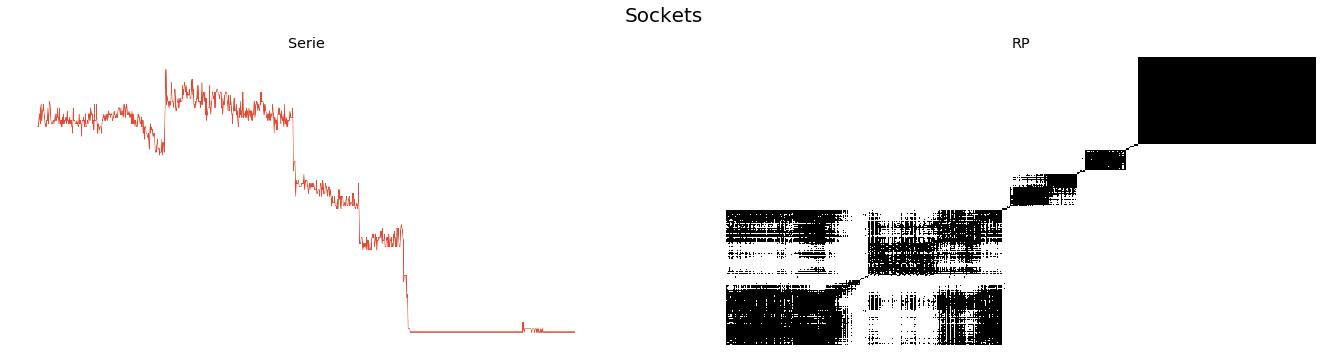

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.


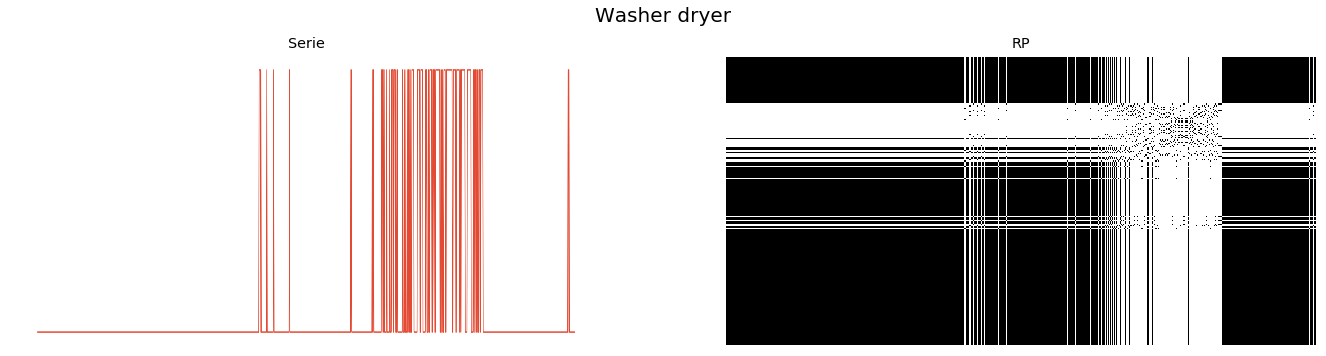

Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


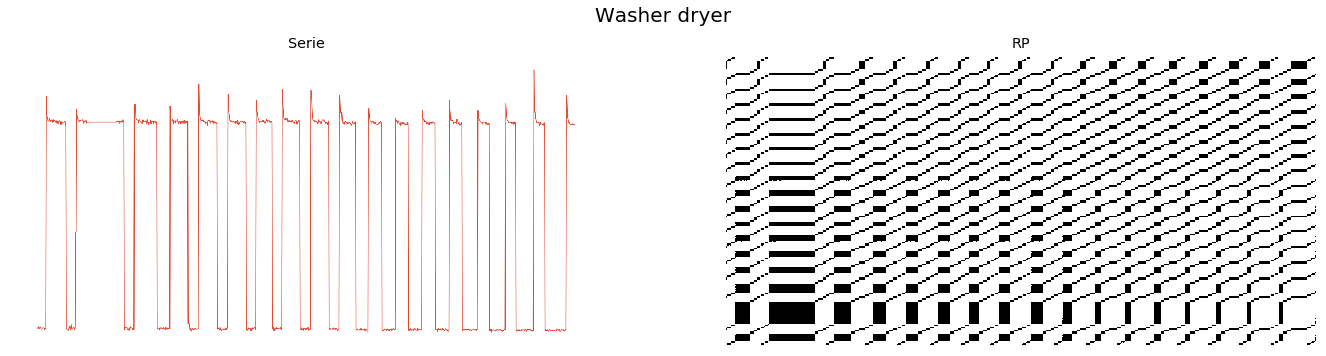

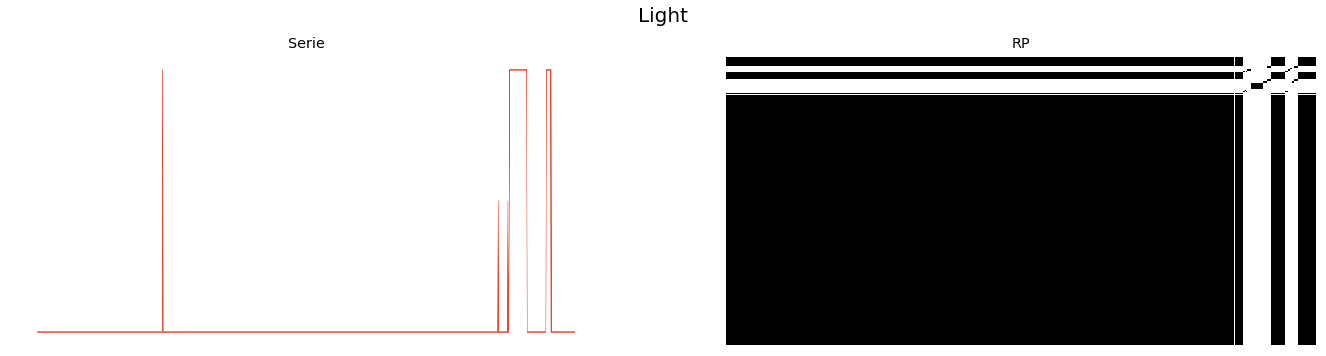

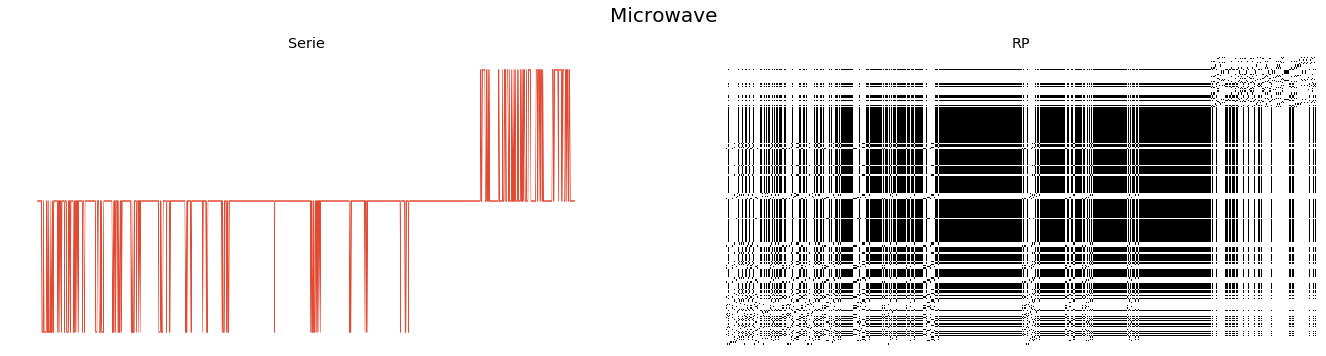

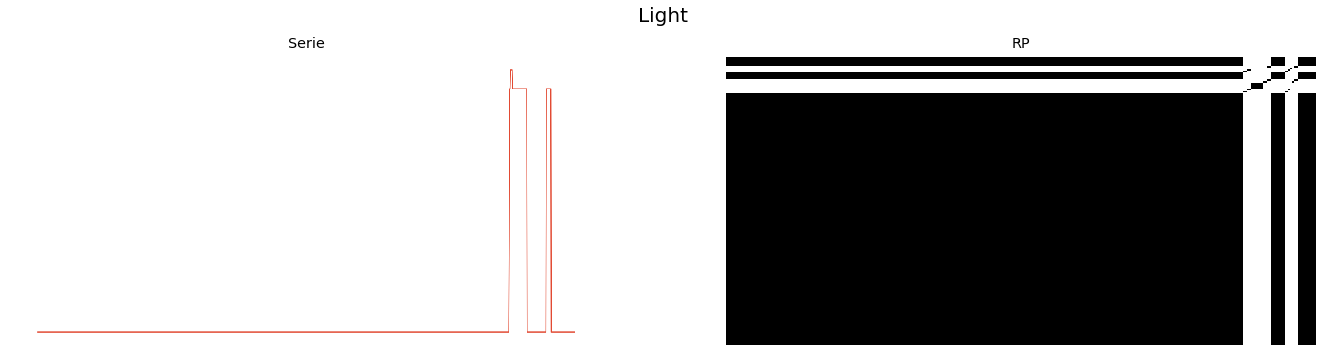

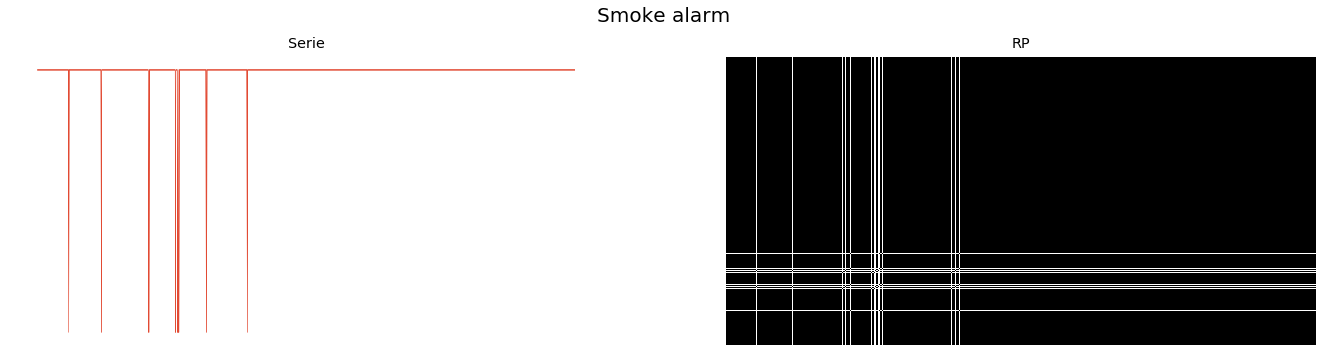

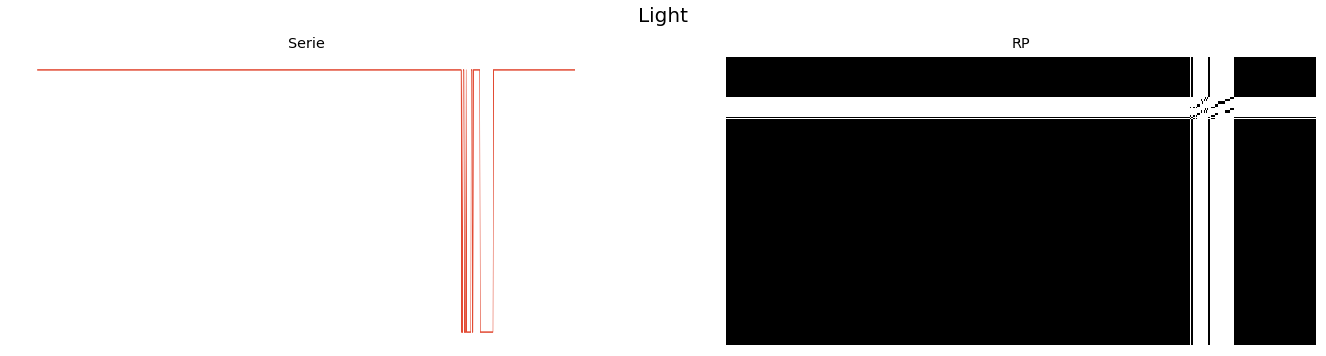

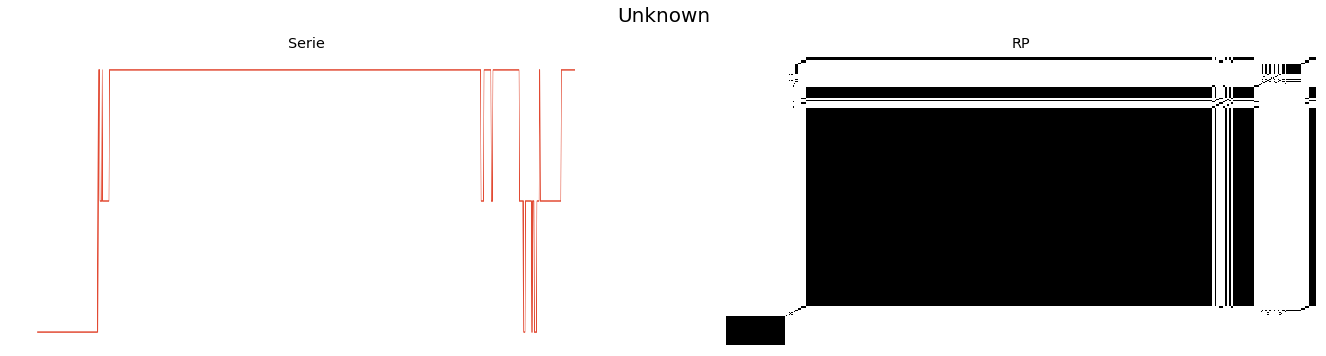

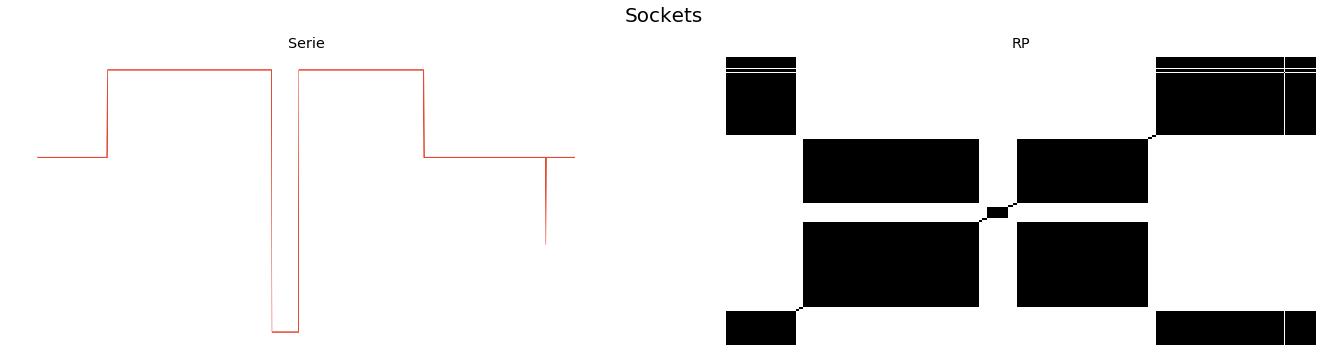

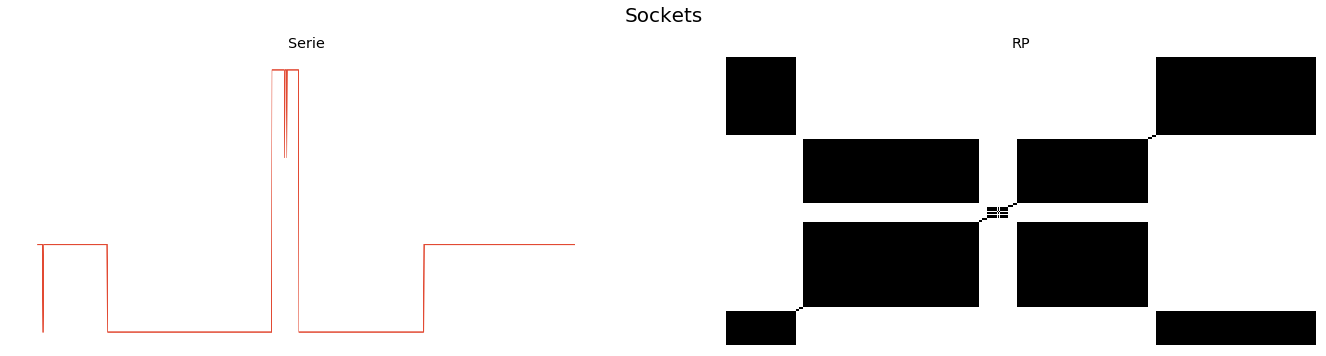

In [29]:
# Plotting RP Window sample by Appliance, and Calculating RQA by RPs.
# Turn interactive plotting off
plt.ion()

samples = [0,0,118,66,4,26,28,7,70,58,13,9,15,16,24,63,28,13,8,22,4,5]

# for i, e in tqdm_notebook(enumerate(house_3.elec.submeters().meters)):
for i, e_i in tqdm_notebook(enumerate(range(1, len(house_3.elec.all_meters())+2))):
    e = house_3.elec[e_i]
    appliance_images_path = os.path.join(images_path, str(e.instance())+"-"+e.label().lower().replace(" ","_"))

    image_serie = plt.imread(os.path.join(appliance_images_path, "{}-chunk_series.png".format(samples[i])))
    image_rp = plt.imread(os.path.join(appliance_images_path, "{}-rp.png".format(samples[i])))

    #fig = plt.figure(figsize=(20,5))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    plt.suptitle(e.label(), fontsize=20)
    
    ax1.set_title('Serie')
    ax1.imshow(image_serie)
    ax1.axis('off')
    
    ax2.set_title('RP')
    ax2.imshow(image_rp)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

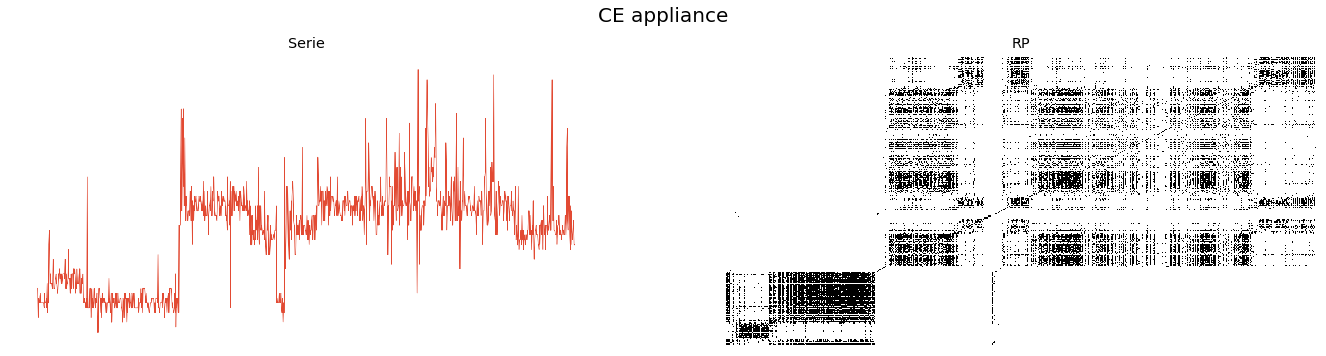

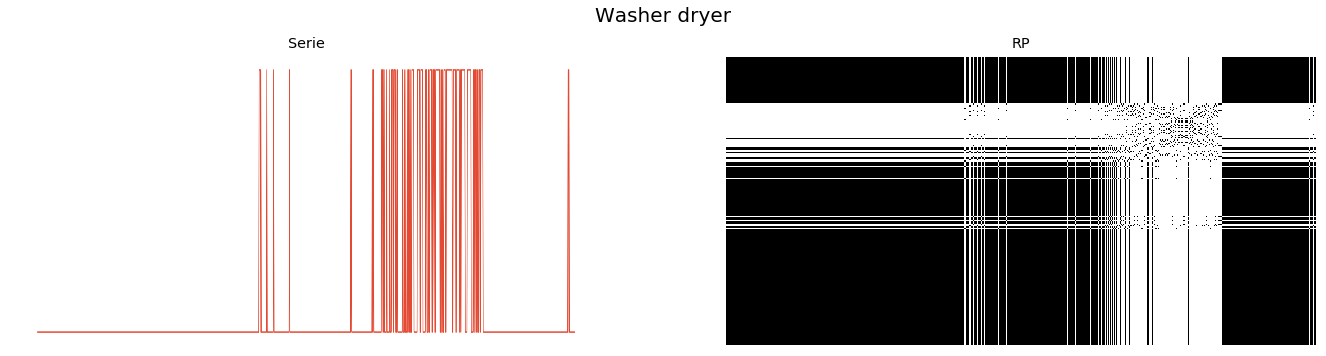

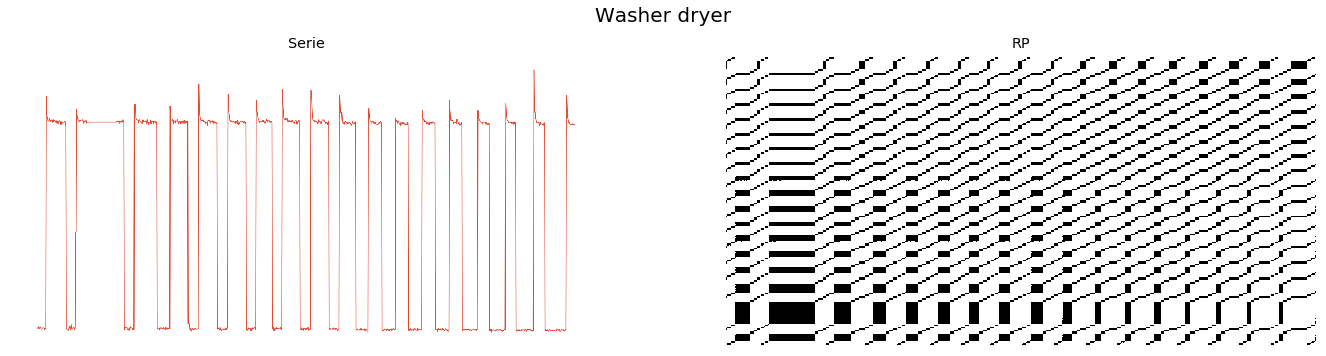

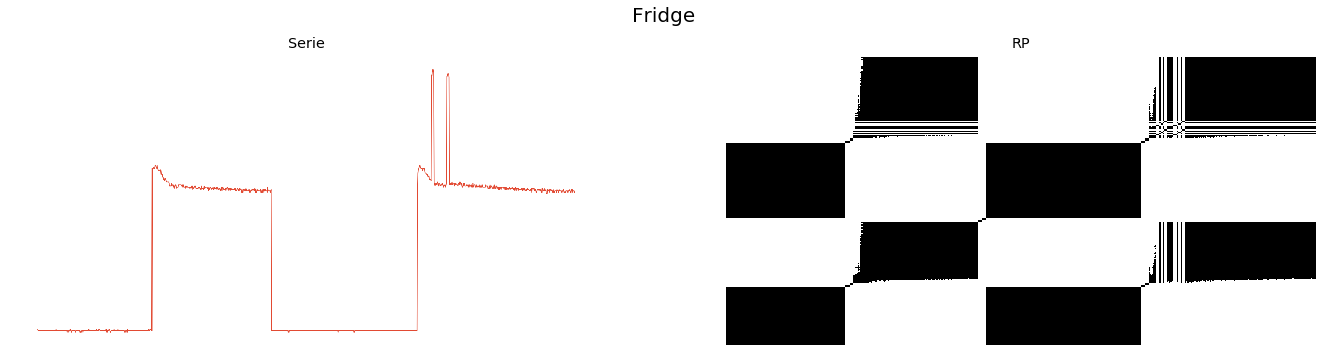

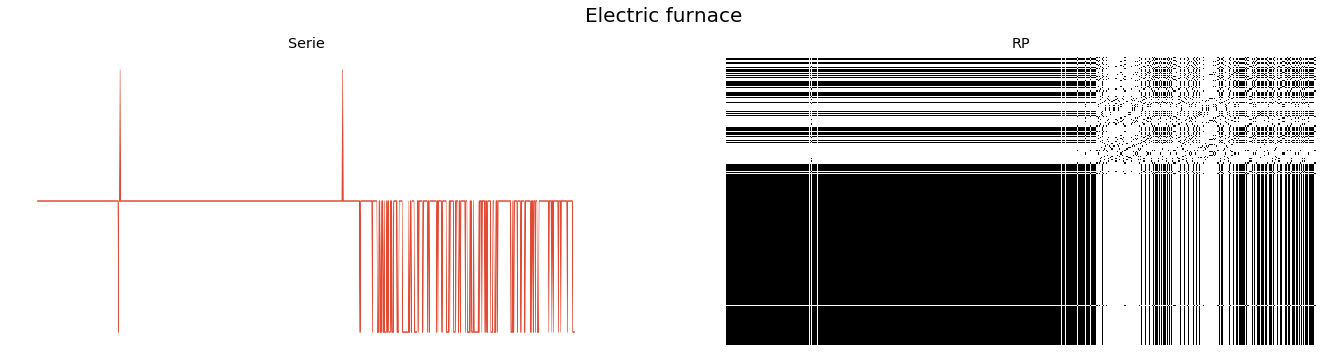

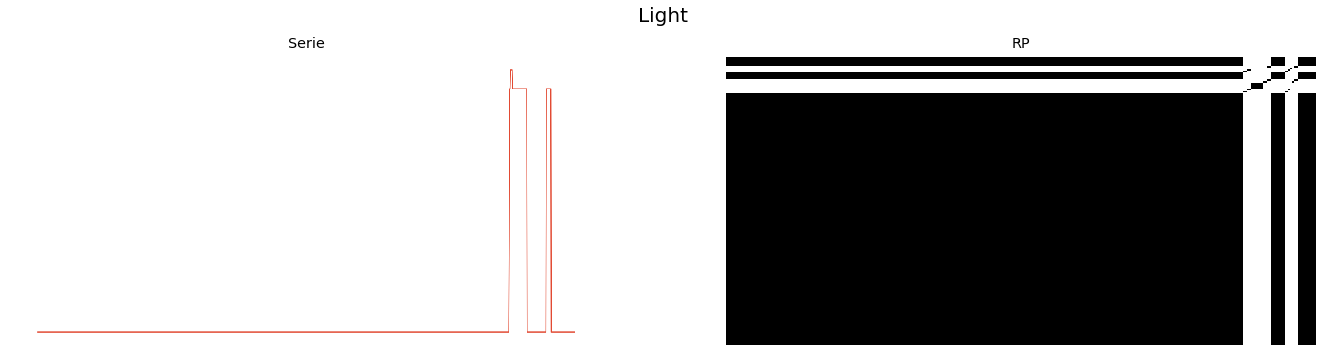

In [30]:
# Exibir apenas aparelhos com maior consumo de energia na serie historica
top_appliances = [
    {"id": 6, "label": "CE appliance"},
    {"id": 13, "label": "Washer dryer"},
    {"id": 14, "label": "Washer dryer"},
    {"id": 7, "label": "Fridge"},
    {"id": 10, "label": "Electric furnace"},
    {"id": 17, "label": "Light"}
]


samples = [0,0,118,66,4,26,28,7,70,58,13,9,15,16,24,63,28,13,8,22,4,5]

plt.ion()

for a in top_appliances:
    
    appliance_images_path = os.path.join(images_path, str(a["id"])+"-"+a["label"].lower().replace(" ","_"))

    image_serie = plt.imread(os.path.join(appliance_images_path, "{}-chunk_series.png".format(samples[a["id"]-1])))
    image_rp = plt.imread(os.path.join(appliance_images_path, "{}-rp.png".format(samples[a["id"]-1])))

    #fig = plt.figure(figsize=(20,5))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    plt.suptitle(a["label"], fontsize=20)
    
    ax1.set_title('Serie')
    ax1.imshow(image_serie)
    ax1.axis('off')
    
    ax2.set_title('RP')
    ax2.imshow(image_rp)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

**CONCLUSÕES:** É possível observar que, apesar de subjetiva, a inspeção visual sugere que o RP evidencia as particularidades da curva de carga de cada aparelho, destacando os padrões inerentes ao funcionamento dos mesmos, resultando em tipologias e texturas únicas para cada classe de aparelho. 

Todavia, é válido destacar que cargas com baixo consumo de energia, ou utilização rara, tem suas curvas "mascaradas" por aparelhos nos quais demandam maior potência para funcionamento. Logo, uma estratégia válida e de maior impacto para a desagregação de energia é implementar mecanismos para a detecção de operação de aparelhos com maior consumo energético.

## Análises de Estatísticas de Recorrência
---
Além da inspeção visual, a seguir são aparesentadas análises adicionais a cerca das recorrências presentes nos dados, as quais são calculadas a partir dos RPs resultantes das janelas de consumo das cargas com maior consumo na residência em questão.

Tais análises são:
    1. Indicadores de Análise Quantitativa de Recorrências (RQA) por aparelho;
    2. Seleção de atributos, a partir de técnicas de Machine Learning;
    2. Projeção de características em espaço reduzido, com PCA e t-SNE.

### RQA - Resumo por Classe/Aparelho

In [ ]:
# RQA Summary by Appliance...
df_rqa = pd.DataFrame(
    data = rqa_data,
    columns = ["Appliance", "Window"] + columns_rqa
)
a = input("Deseja persistir os dados? [S]im ou [N]ão: ")
if str(a.upper()) == "S":
    df_rqa.to_csv( os.path.join(windows_data_path, "df_rqa.csv"), index=False )

In [32]:
# Media dos indicadores de RQA para cada aparelho
df_rqa_mean = df_rqa.groupby('Appliance')[df_rqa.columns[5:]].mean()

df_rqa_mean.to_csv( os.path.join(windows_data_path, "df_rqa_mean.csv"), index=True )
df_rqa_mean

Recurrence rate (RR)  Determinism (DET)  \
Appliance                                                          
1 - Site meter                       0.408622           0.975540   
10 - Electric furnace                0.778679           0.982029   
11 - Light                           0.570158           0.962704   
12 - Sockets                         0.497796           0.853560   
13 - Washer dryer                    0.802292           0.995502   
14 - Washer dryer                    0.835135           0.998220   
15 - Light                           0.628601           0.966382   
16 - Microwave                       0.721095           0.963581   
17 - Light                           0.542818           0.948443   
18 - Smoke alarm                     0.664925           0.930757   
19 - Light                           0.738691           0.989638   
2 - Site meter                       0.441041           0.997860   
20 - Unknown                         0.709900           0.991072   
21 - Sockets                         0.755332           0.941819   
22 - Sockets                         0.880383           0.994807   
3 - Sockets                          0.523822           0.973497   
4 - Sockets                          0.712897           0.969877   
5 - Light                            0.824434           0.991313   
6 - CE appliance                     0.281055           0.839994   
7 - Fridge                           0.527274           0.998920   
8 - Waste disposal unit              0.807487           0.986226   
9 - Dish washer                      0.708535           0.975532   

                         Average diagonal line length (L)  \
Appliance                                                   
1 - Site meter                                  75.250003   
10 - Electric furnace                          108.815371   
11 - Light                                     146.196182   
12 - Sockets                                    61.585255   
13 - Washer dryer                              123.867187   
14 - Washer dryer                              129.623391   
15 - Light                                      67.782032   
16 - Microwave                                  73.148731   
17 - Light                                     149.845811   
18 - Smoke alarm                                28.026783   
19 - Light                                     117.768081   
2 - Site meter                                 126.739676   
20 - Unknown                                   198.869071   
21 - Sockets                                    77.822068   
22 - Sockets                                    61.529661   
3 - Sockets                                     84.276966   
4 - Sockets                                     66.743100   
5 - Light                                       86.626172   
6 - CE appliance                                16.959089   
7 - Fridge                                     131.176008   
8 - Waste disposal unit                         86.148217   
9 - Dish washer                                 43.911716   

                         Longest diagonal line length (L_max)  \
Appliance                                                       
1 - Site meter                                     427.492857   
10 - Electric furnace                              666.288136   
11 - Light                                         611.444444   
12 - Sockets                                       463.894737   
13 - Washer dryer                                  774.939394   
14 - Washer dryer                                  778.434783   
15 - Light                                         598.493506   
16 - Microwave                                     611.726496   
17 - Light                                         596.844156   
18 - Smoke alarm                                   363.264706   
19 - Light                                         550.718519   
2 - Site meter                                     501.457143   
20 - Unknown     

In [33]:
# Selecionado TOP-5 appliances
top_appliances_label = ["{} - {}".format(a["id"], a["label"]) for a in top_appliances]
df_analysis = df_rqa[ df_rqa["Appliance"].isin(top_appliances_label) ]

In [34]:
# Atualizando labels
appliance_labels = []
for a in df_analysis["Appliance"].values:
    al = a.split("-")
    al = "{} - #{}".format( al[-1].strip(), a[0].strip() )
    appliance_labels.append( al )
    
df_analysis["Appliance_label"] = appliance_labels

<Figure size 2880x1440 with 0 Axes>

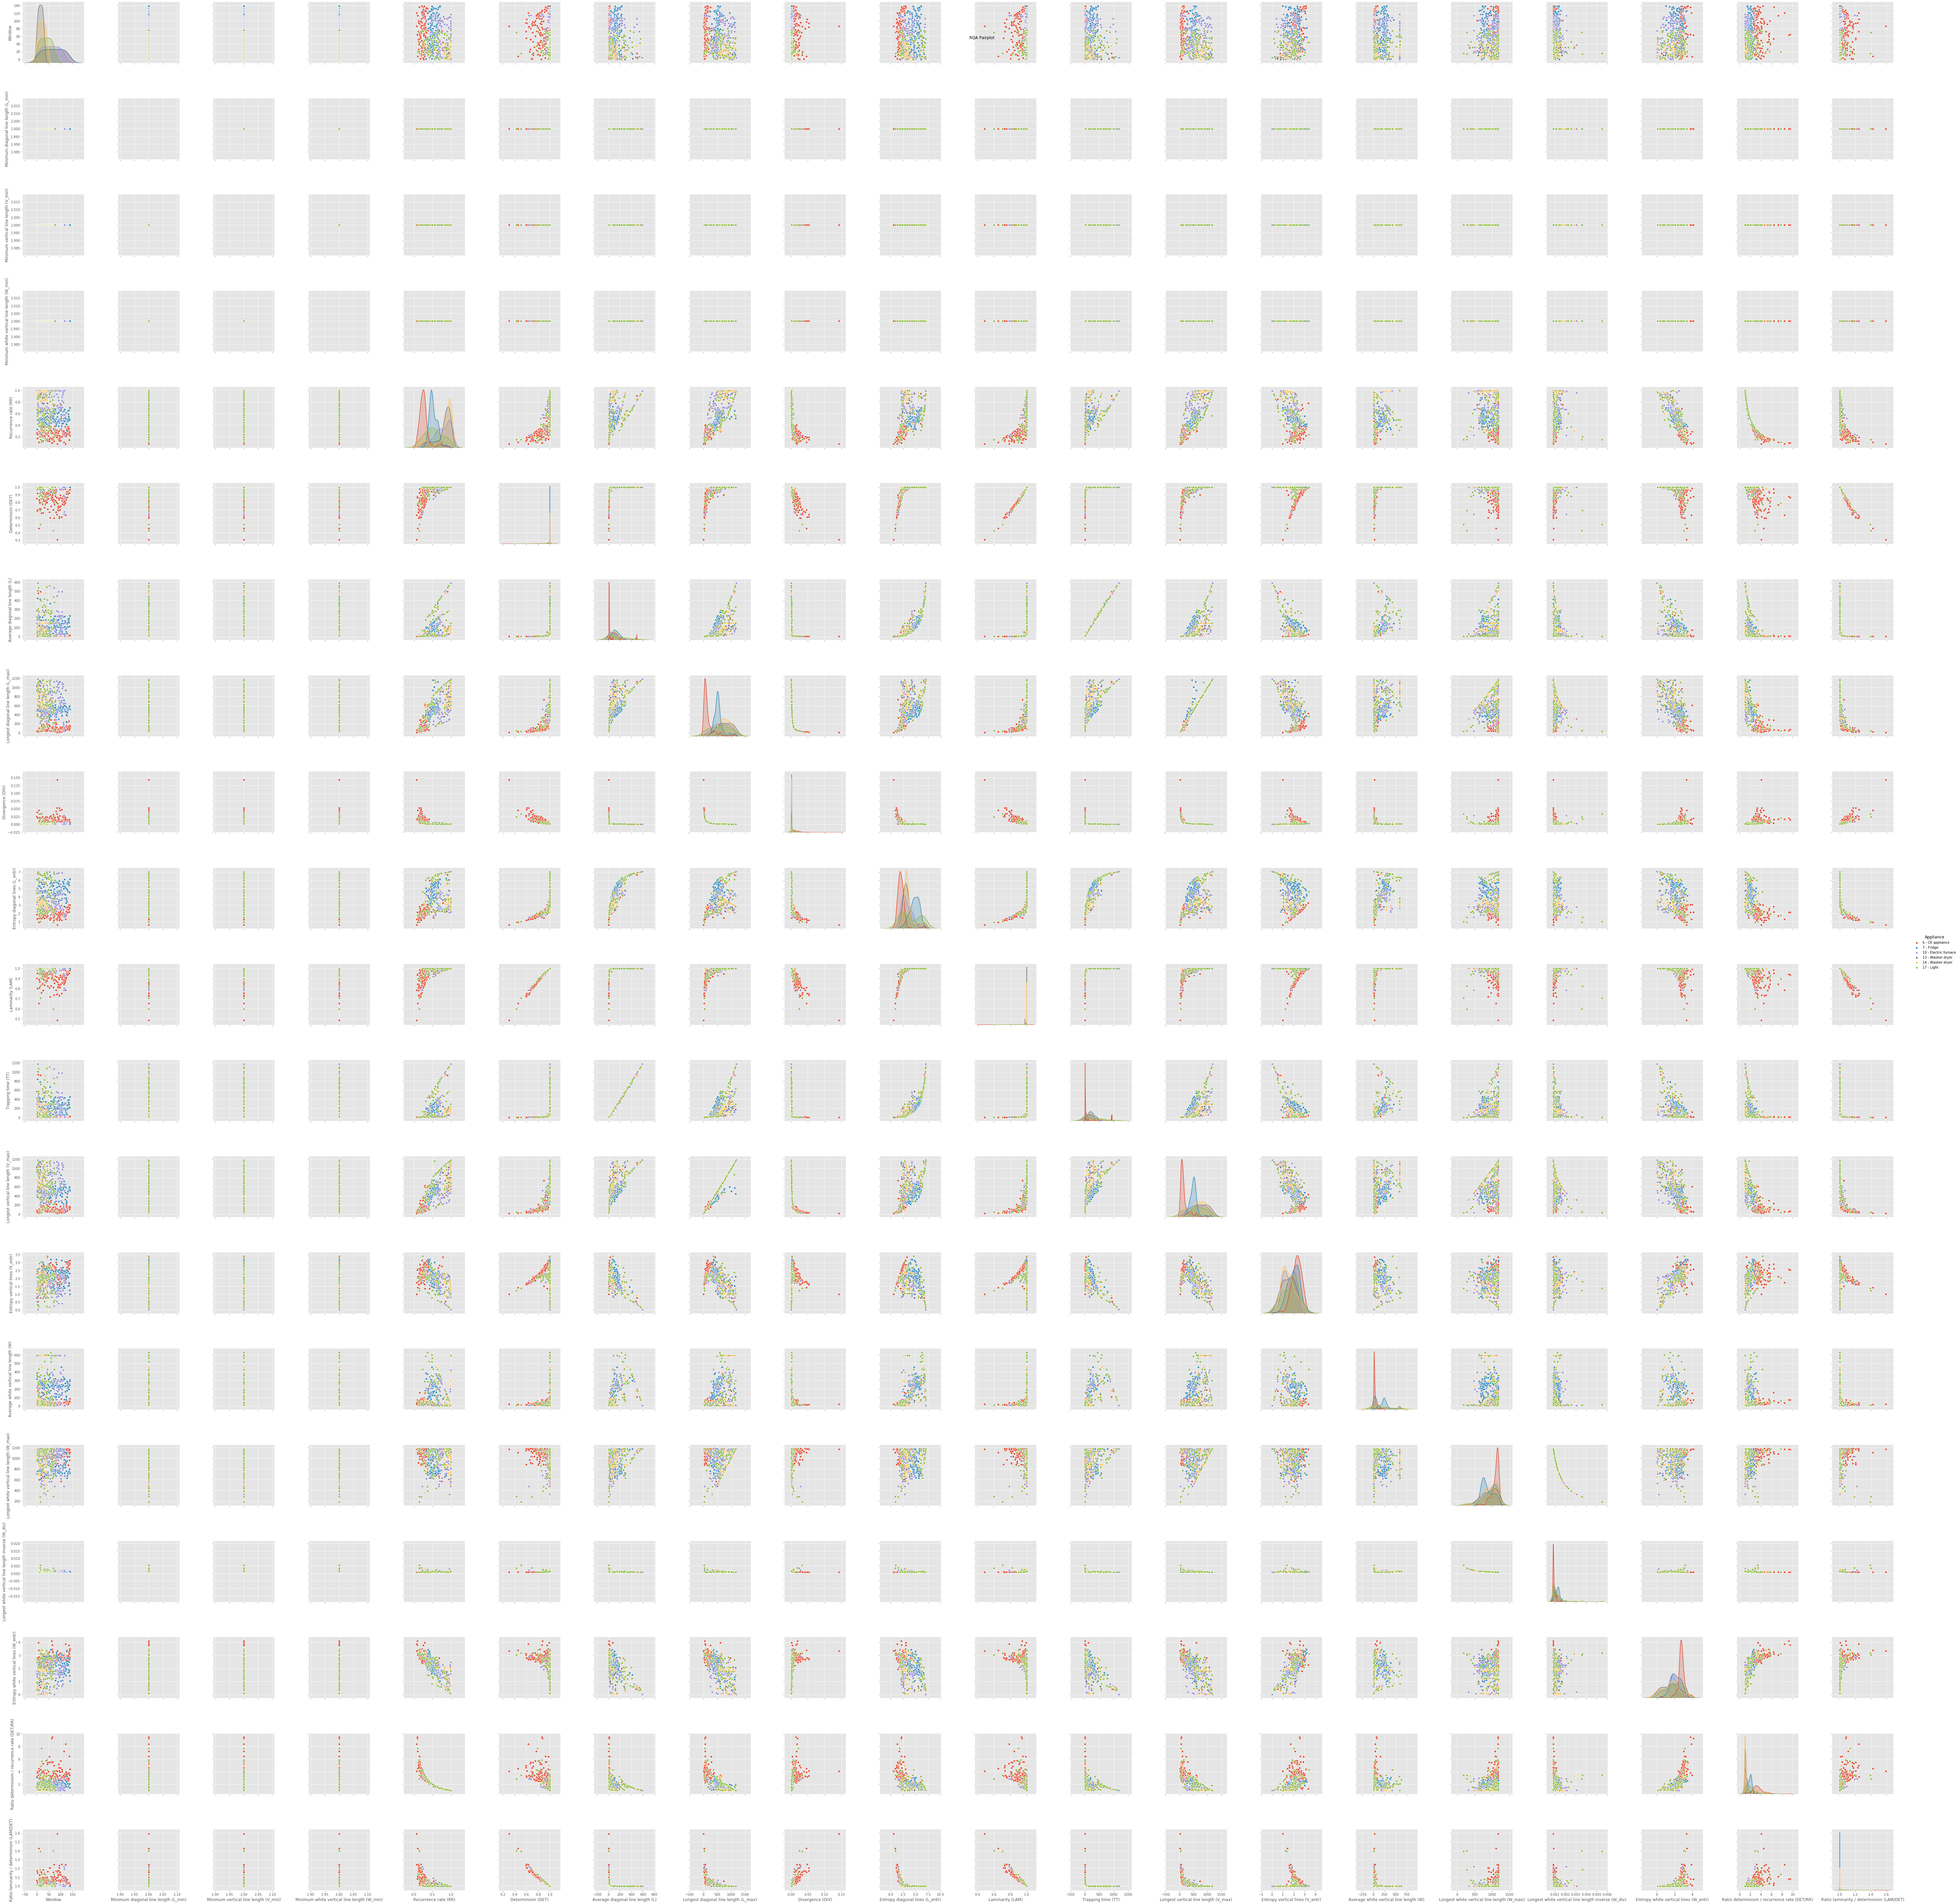

In [35]:
fig = plt.figure(figsize=(40,20))
g = sns.pairplot(df_analysis, hue="Appliance", size =4);
plt.suptitle("RQA Pairplot");

**CONCLUSÕES:** observa-se que algumas estatisitcas de RQA resultam em distribuições com maior poder discriminativo entre as classes. 

Todavia, diante do grande número de atributos/ existentes, é útil selecionarmos um subconjunto consistente destas estatísticas, uma vez que nosso objetivo é compreender a caracterização das distribuições no conjunto de dados disponível. Para isto, iremos lançar mão de algumas técnicas de *Feature selection*.

### Feature Selection

In [36]:
# Insumos para analise
features_selection = []

available_features = df_analysis.columns[2:-1].tolist()
y = df_analysis["Appliance"].values
num_features = 5

rcParams['axes.titlepad'] = 20

Features selecionadas:
['Entropy white vertical lines (W_entr)', 'Ratio determinism / recurrence rate (DET/RR)', 'Recurrence rate (RR)', 'Longest diagonal line length (L_max)', 'Longest vertical line length (V_max)']


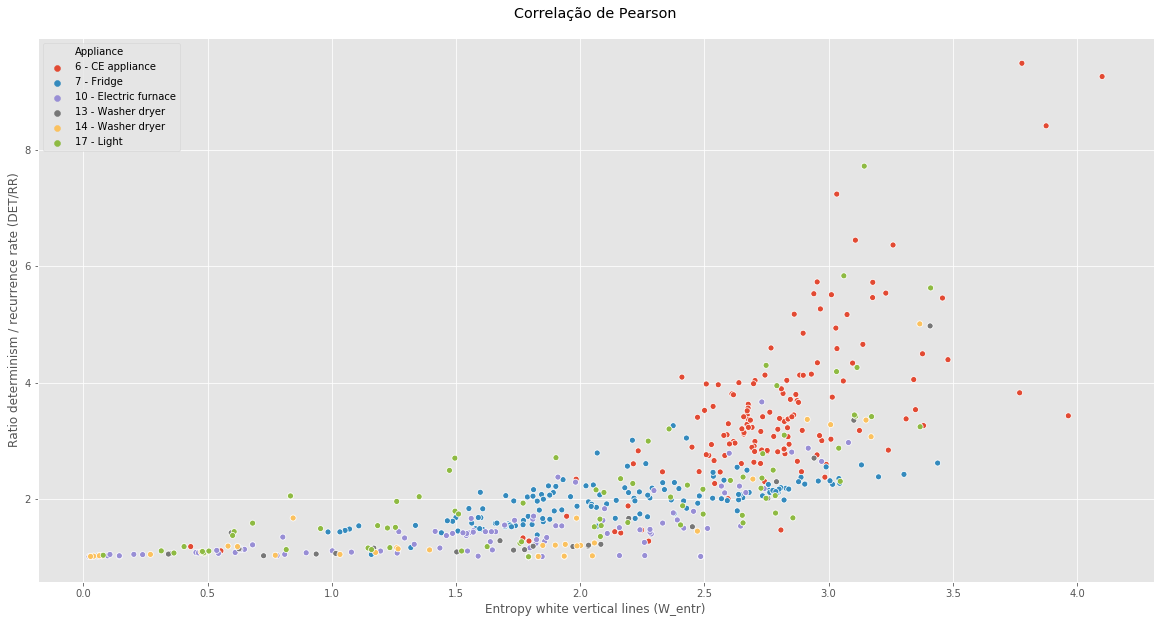

In [37]:
# MÉTODO 1: Correção de Pearson (Metric-based)
def corr_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    y_ = pd.factorize(y)[0]
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i].values, y_)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = corr_selector(df_analysis[available_features], y, num_features)
print("Features selecionadas:")
print(cor_feature)

fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=cor_feature[0], y=cor_feature[1], hue="Appliance", data=df_analysis[cor_feature + ["Appliance"]]);
plt.title("Correlação de Pearson");

features_selection.append(["PEARSON"] + cor_feature)

Features selecionadas:
['Recurrence rate (RR)', 'Longest diagonal line length (L_max)', 'Longest vertical line length (V_max)', 'Ratio determinism / recurrence rate (DET/RR)', 'Ratio laminarity / determinism (LAM/DET)']


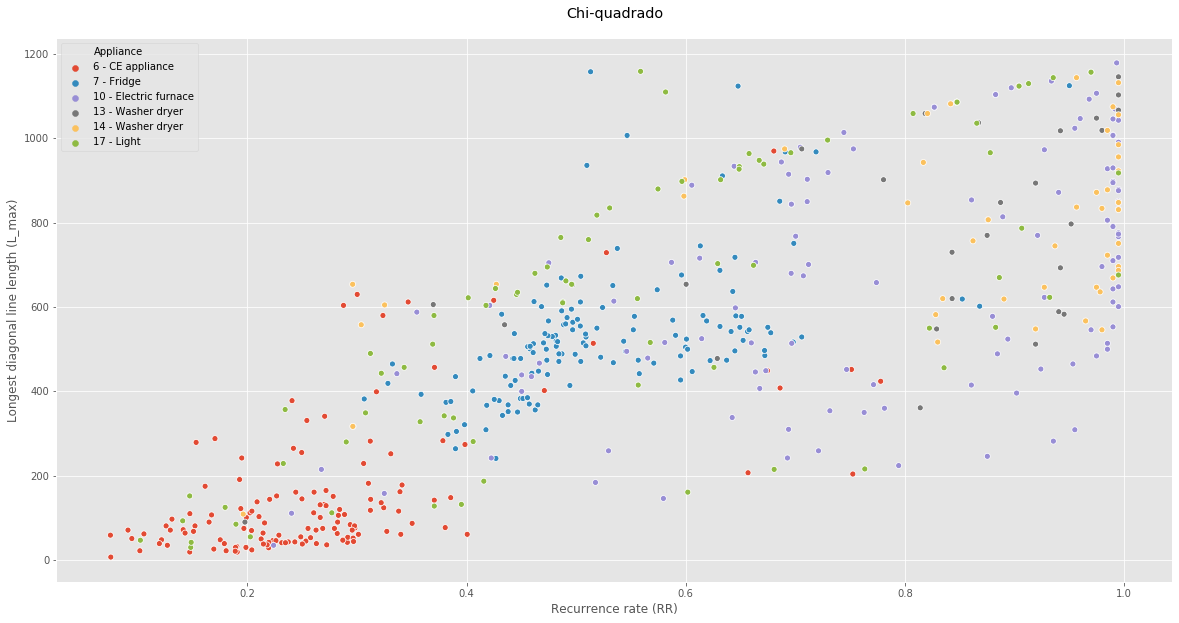

In [38]:
# MÉTODO 2: Chi-Squared (Filter-based)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X = df_analysis[available_features]
X_norm = MinMaxScaler().fit_transform(X)
y = pd.factorize(df_analysis["Appliance"].values)[0]

chi_selector = SelectKBest(chi2, k=num_features)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print("Features selecionadas:")
print(chi_feature)

fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=chi_feature[0], y=chi_feature[1], hue="Appliance", data=df_analysis[chi_feature + ["Appliance"]]);
plt.title("Chi-quadrado");

features_selection.append(["Chi-Squared"] + chi_feature)

Features selecionadas:
['Recurrence rate (RR)', 'Entropy diagonal lines (L_entr)', 'Longest vertical line length (V_max)', 'Longest white vertical line length (W_max)', 'Ratio determinism / recurrence rate (DET/RR)']


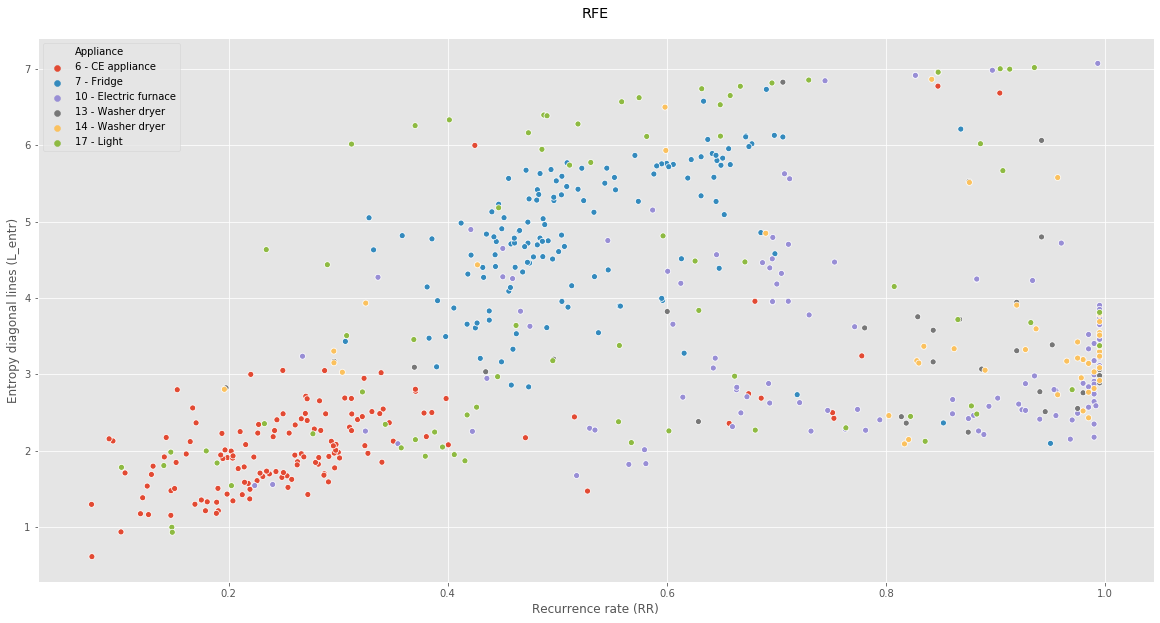

In [39]:
# MÉTODO 3: Recursive Feature Elimination (Wrapped-based)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = df_analysis[available_features]
X_norm = MinMaxScaler().fit_transform(X)

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_features, step=1, verbose=0)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print("Features selecionadas:")
print(rfe_feature)

fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=rfe_feature[0], y=rfe_feature[1], hue="Appliance", data=df_analysis[rfe_feature + ["Appliance"]]);
plt.title("RFE");

features_selection.append(["RFE"] + rfe_feature)

Features selecionadas:
['Recurrence rate (RR)', 'Entropy diagonal lines (L_entr)', 'Average white vertical line length (W)', 'Longest white vertical line length (W_max)', 'Ratio determinism / recurrence rate (DET/RR)']


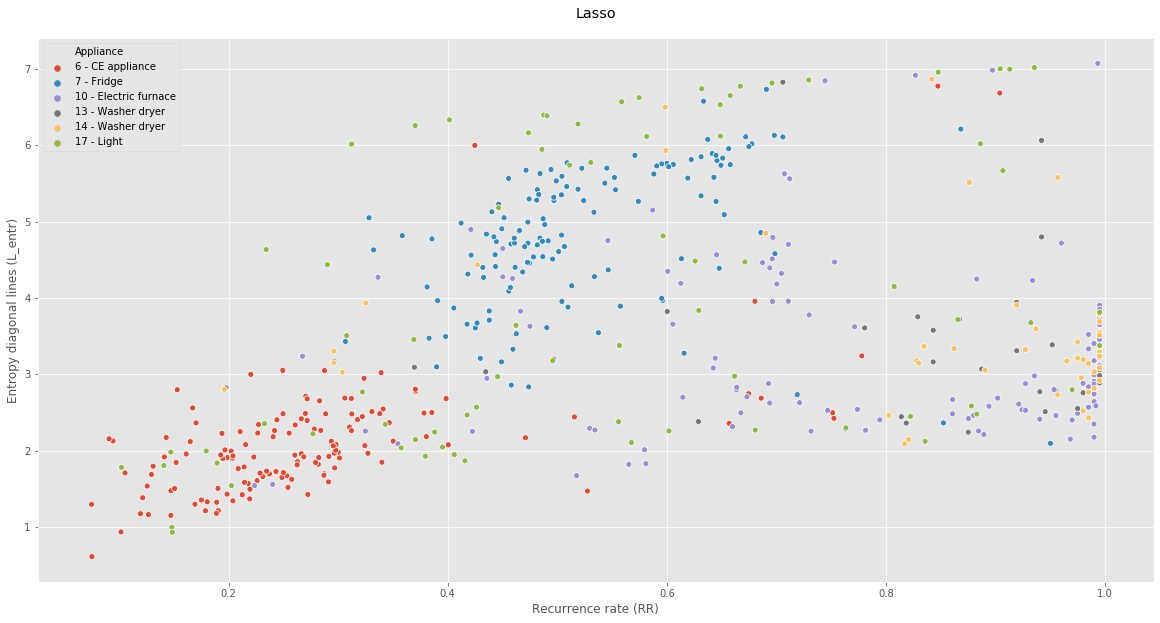

In [41]:
# MÉTODO 4: Lasso (Embed-based)
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

X = df_analysis[available_features]
X_norm = MinMaxScaler().fit_transform(X)

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=num_features)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print("Features selecionadas:")
print(embeded_lr_feature)

fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=embeded_lr_feature[0], y=embeded_lr_feature[1], hue="Appliance", data=df_analysis[embeded_lr_feature + ["Appliance"]]);
plt.title("Lasso");

features_selection.append(["Lasso"] + embeded_lr_feature)

Features selecionadas:
['Recurrence rate (RR)', 'Laminarity (LAM)', 'Trapping time (TT)', 'Longest vertical line length (V_max)', 'Ratio determinism / recurrence rate (DET/RR)']


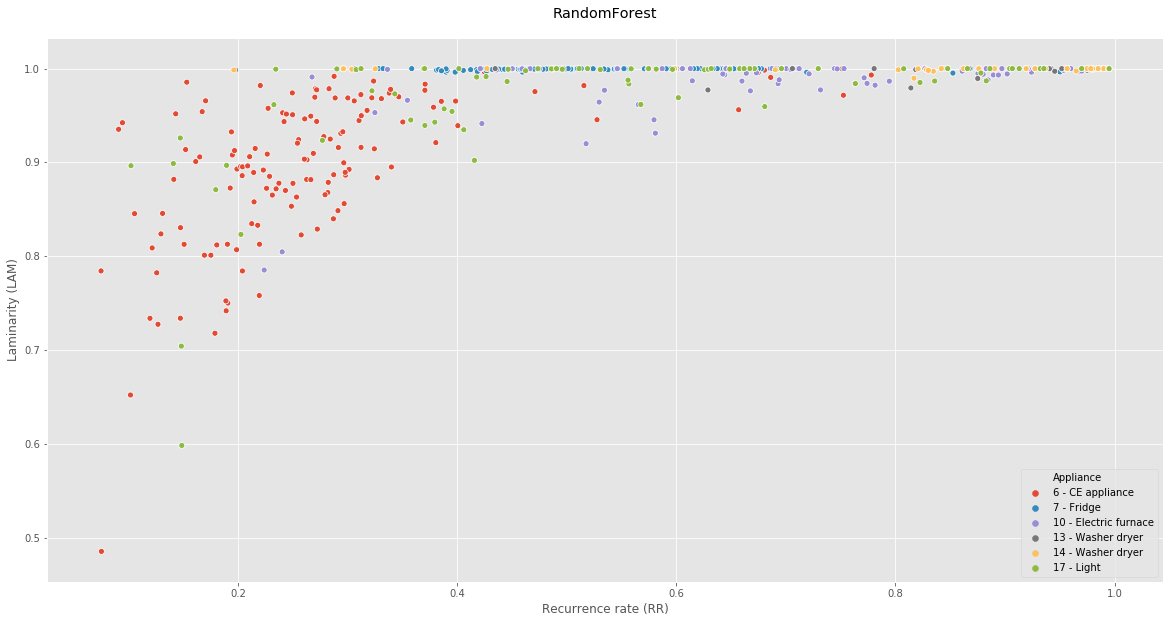

In [42]:
# MÉTODO 5: Floresta aleatória (Embed-based)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

X = df_analysis[available_features]
X_norm = MinMaxScaler().fit_transform(X)

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=num_features)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print("Features selecionadas:")
print(embeded_rf_feature)

fig = plt.figure(figsize=(20,10))
sns.scatterplot(
    x=embeded_rf_feature[0], 
    y=embeded_rf_feature[1], 
    hue="Appliance", 
    data=df_analysis[embeded_rf_feature + ["Appliance"]]
);
plt.title("RandomForest");

features_selection.append(["Random-Forest"] + embeded_rf_feature)

In [43]:
df_feature_selection = pd.DataFrame(
    data = features_selection,
    columns = ["Method"] + ["Feature #{}".format(i) for i in range(1, num_features+1)]
)
df_feature_selection

Method                             Feature #1  \
0        PEARSON  Entropy white vertical lines (W_entr)   
1    Chi-Squared                   Recurrence rate (RR)   
2            RFE                   Recurrence rate (RR)   
3          Lasso                   Recurrence rate (RR)   
4  Random-Forest                   Recurrence rate (RR)   

                                     Feature #2  \
0  Ratio determinism / recurrence rate (DET/RR)   
1          Longest diagonal line length (L_max)   
2               Entropy diagonal lines (L_entr)   
3               Entropy diagonal lines (L_entr)   
4                              Laminarity (LAM)   

                               Feature #3  \
0                    Recurrence rate (RR)   
1    Longest vertical line length (V_max)   
2    Longest vertical line length (V_max)   
3  Average white vertical line length (W)   
4                      Trapping time (TT)   

                                     Feature #4  \
0          Longest diagonal line length (L_max)   
1  Ratio determinism / recurrence rate (DET/RR)   
2    Longest white vertical line length (W_max)   
3    Longest white vertical line length (W_max)   
4          Longest vertical line length (V_max)   

                                     Feature #5  
0          Longest vertical line length (V_max)  
1      Ratio laminarity / determinism (LAM/DET)  
2  Ratio determinism / recurrence rate (DET/RR)  
3  Ratio determinism / recurrence rate (DET/RR)  
4  Ratio determinism / recurrence rate (DET/RR)

In [44]:
from collections import Counter
values = []
for v in df_feature_selection.iloc[:, 1:].values:
    for v_ in v:
        values.append(v_)
        
Counter(values).most_common()

[('Ratio determinism / recurrence rate (DET/RR)', 5),
 ('Recurrence rate (RR)', 5),
 ('Longest vertical line length (V_max)', 4),
 ('Longest diagonal line length (L_max)', 2),
 ('Entropy diagonal lines (L_entr)', 2),
 ('Longest white vertical line length (W_max)', 2),
 ('Entropy white vertical lines (W_entr)', 1),
 ('Ratio laminarity / determinism (LAM/DET)', 1),
 ('Average white vertical line length (W)', 1),
 ('Laminarity (LAM)', 1),
 ('Trapping time (TT)', 1)]

#### Visualização das features escolhidas

In [45]:
useful_columns_rqa = [key for key, count in Counter(values).most_common(4)]
# useful_columns_rqa = [
#     'Recurrence rate (RR)', 
#     'Ratio determinism / recurrence rate (DET/RR)', 
#     'Window',
#     'Longest vertical line length (V_max)'
# ]
useful_columns_rqa

['Ratio determinism / recurrence rate (DET/RR)',
 'Recurrence rate (RR)',
 'Longest vertical line length (V_max)',
 'Longest diagonal line length (L_max)']

<Figure size 1440x720 with 0 Axes>

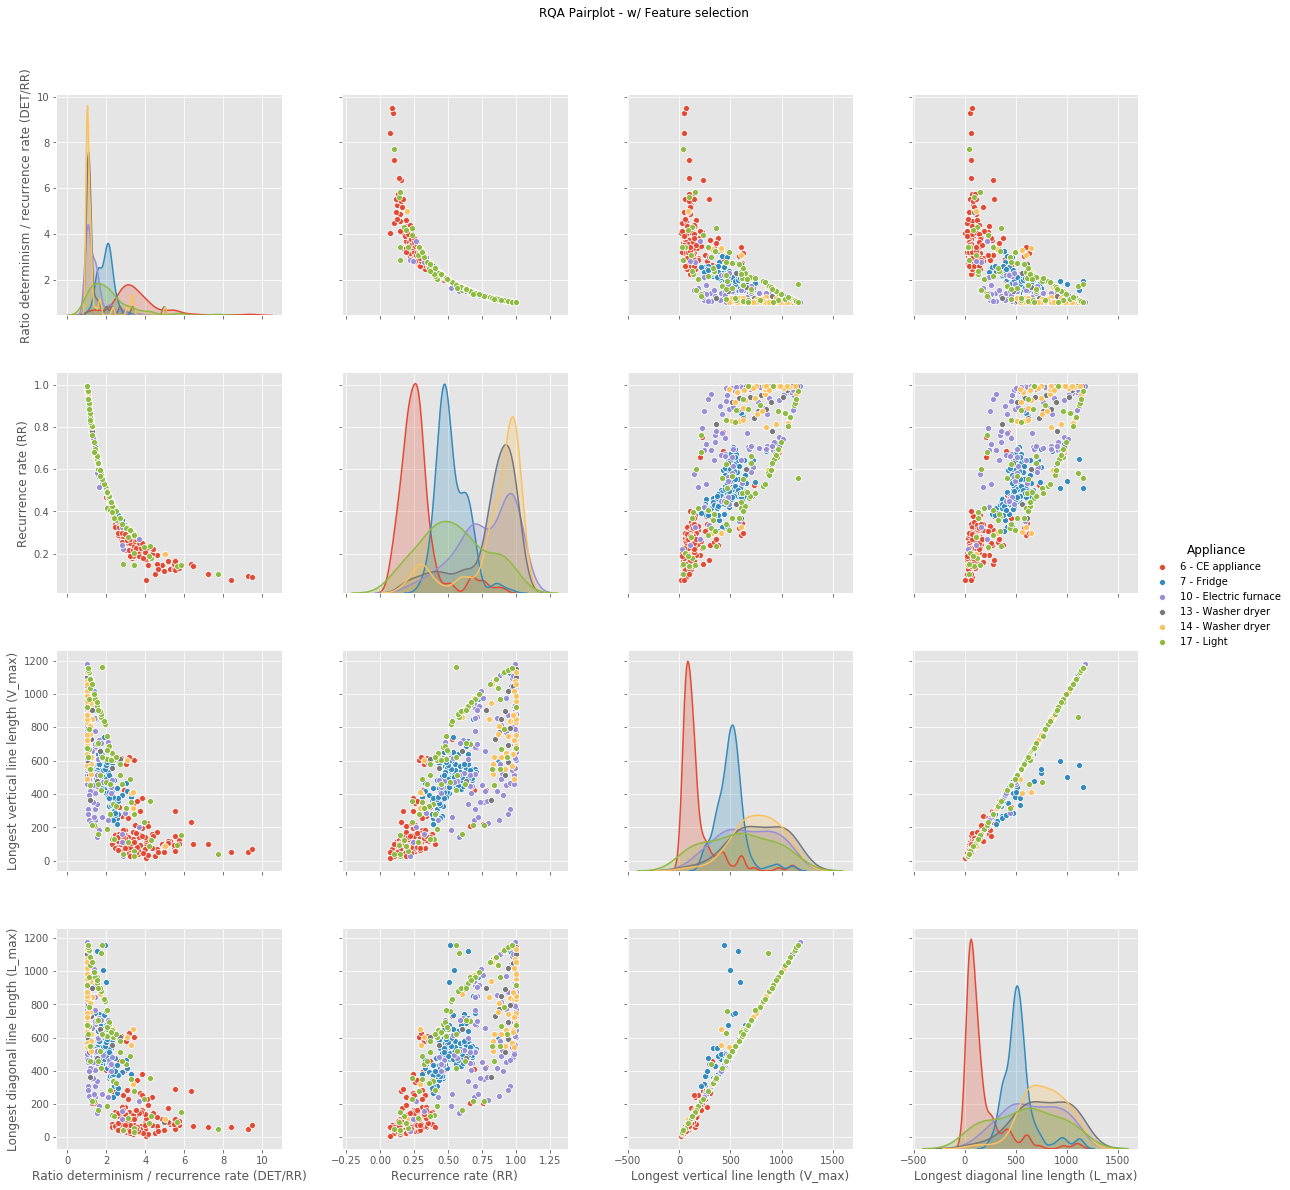

In [46]:
fig = plt.figure(figsize=(20,10));
ax = sns.pairplot(df_analysis[["Appliance"]+useful_columns_rqa], hue="Appliance", size =4);
plt.suptitle("RQA Pairplot - w/ Feature selection", y=1.03);
# plt.show()

**CONCLUSÕES PARCIAIS:** De modo geral, é possível observar que a seleção de atributos filtrou 4 estatísticas que mutuamente descrevem as distribuições das classes, denotando o poder discrimativo dos RPs para os 5 principais aparelhos presentes na residência analisada.

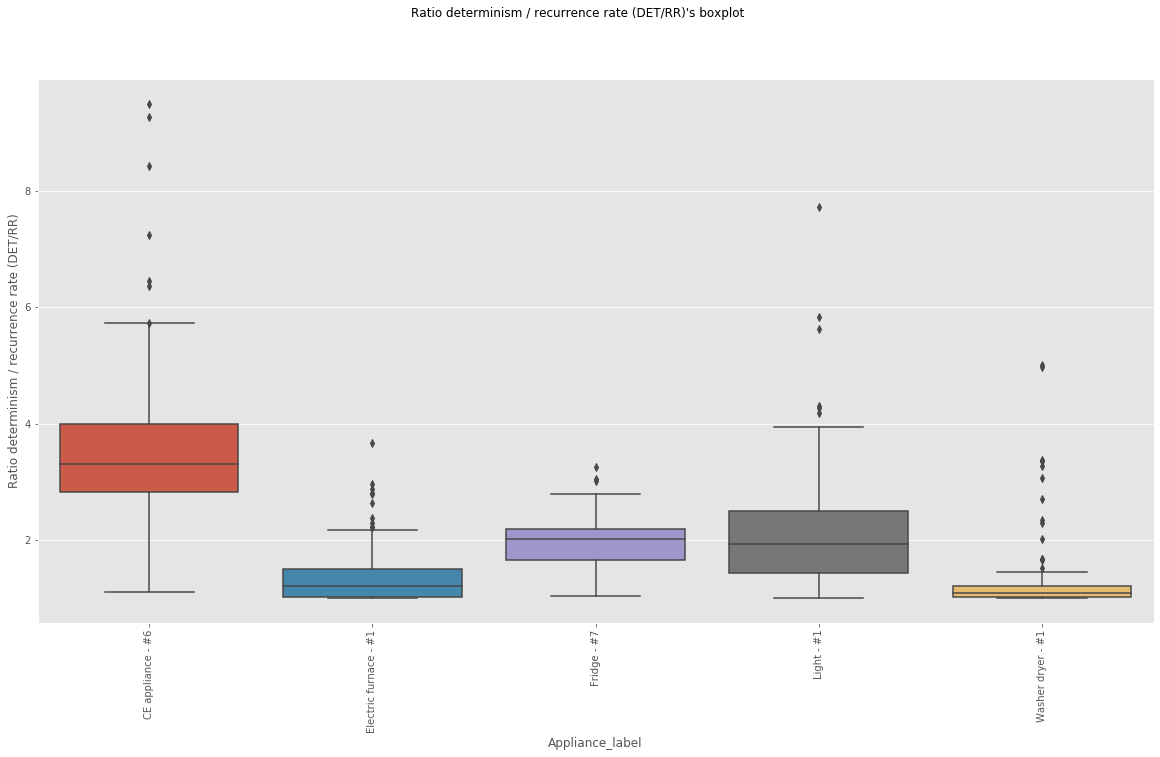

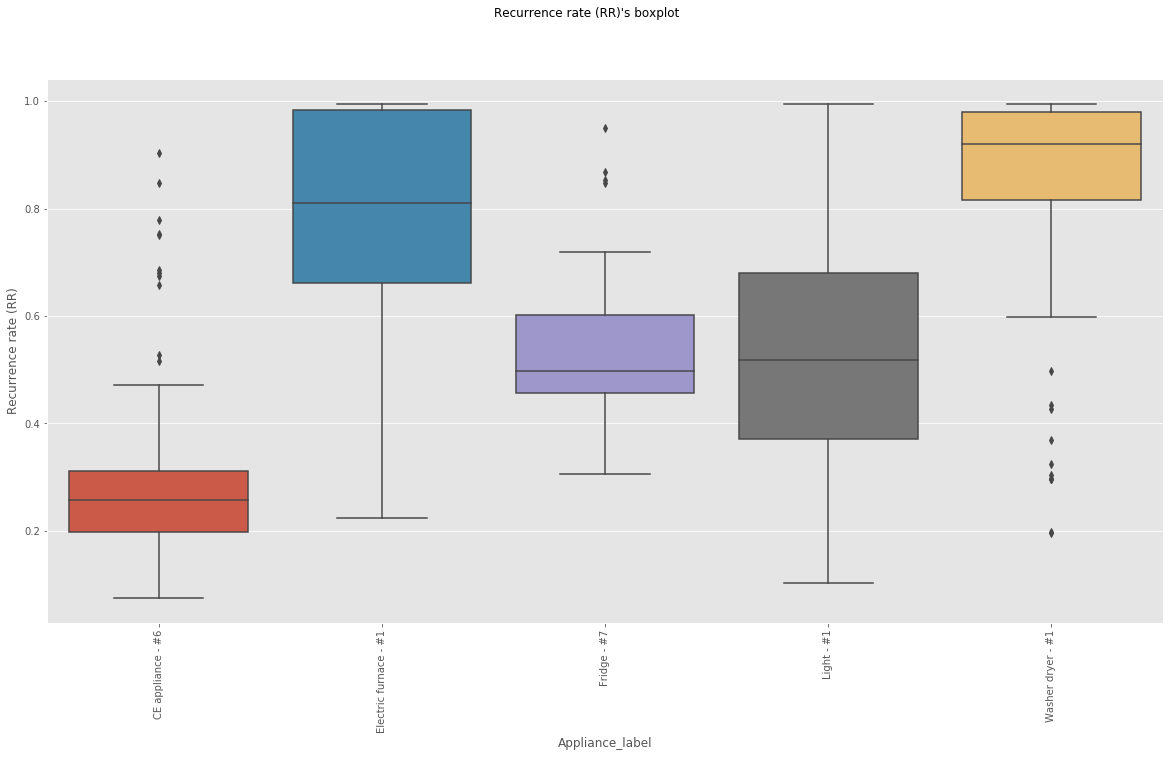

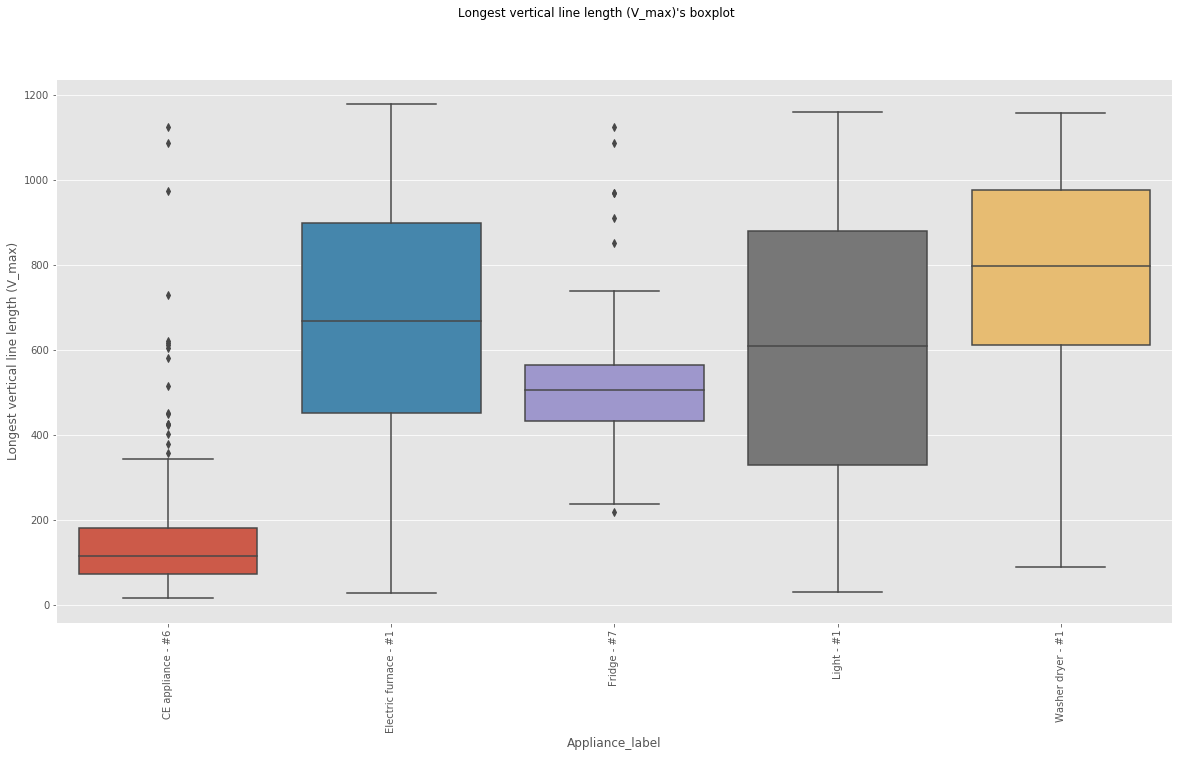

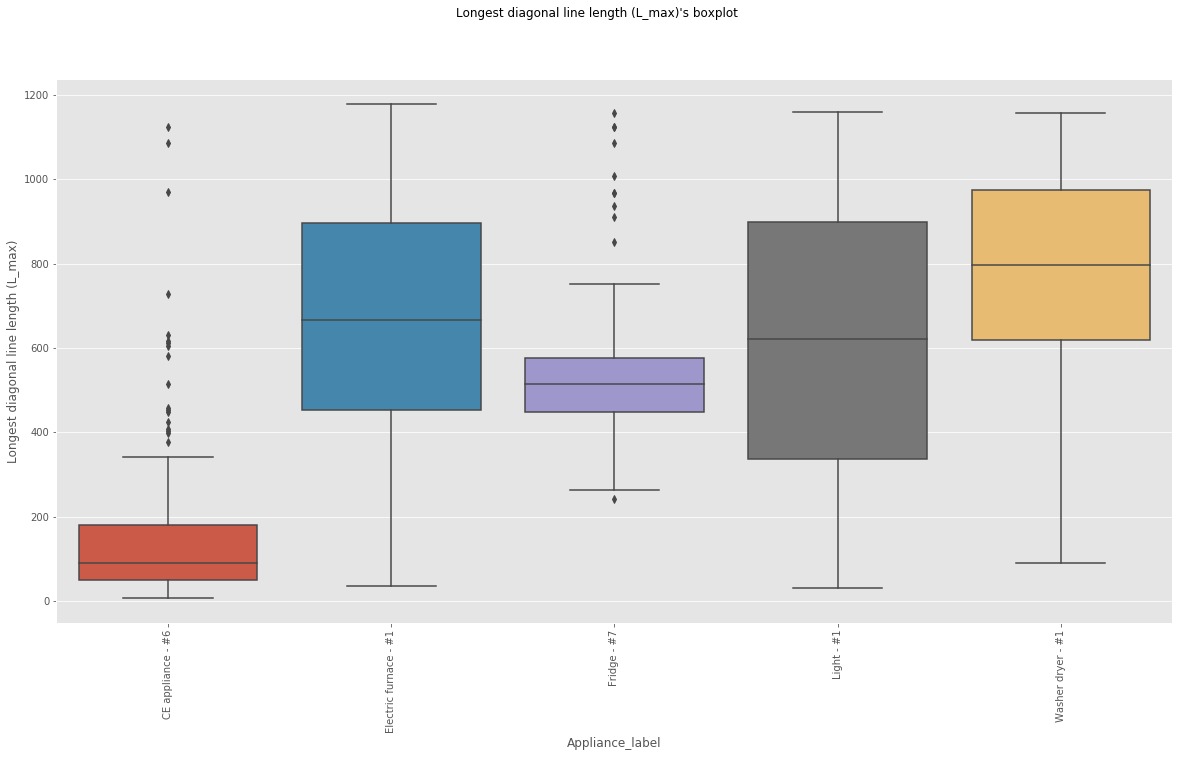

In [47]:
# useful_columns_rqa = list(set(values))

# for column in tqdm_notebook(useful_columns_rqa):
for column in tqdm_notebook(useful_columns_rqa):
    fig = plt.figure(figsize=(20,10))
    ax = sns.boxplot(
        x="Appliance_label", 
        y=column, 
        order = sorted([a for a in df_analysis["Appliance_label"].unique()]),
        data=df_analysis)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.suptitle("{}'s boxplot".format(column))
    plt.show()

**CONCLUSÕES:** ao analisar individualmente a distribuição de valores para cada uma das estatísticas, corroboramos a evidência anterior no que diz respeito as distribuições inviduais de cada aparelho. 

### Redução da Dimensionalidade - PCA (Linear)

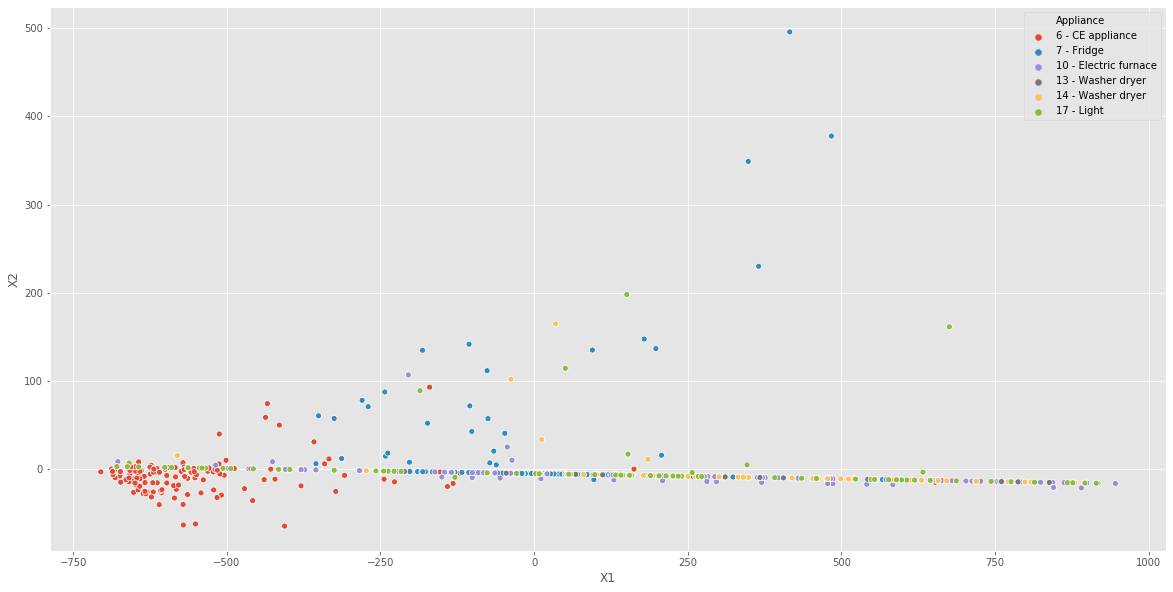

In [48]:
pca = PCA(n_components=2)
X_projected = pca.fit_transform( df_analysis[ useful_columns_rqa ].values )

df_projected = pd.DataFrame(X_projected, columns=["X1","X2"])
df_projected["Appliance"] = df_analysis["Appliance"].values
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x="X1", y="X2", hue="Appliance", data=df_projected);

In [49]:
print(
    "Variância explicada pelas componentes: {}%".format(
        round(sum(pca.explained_variance_ratio_)*100, 3)
    ), 
    list(pca.explained_variance_ratio_)
)

Variância explicada pelas componentes: 100.0% [0.9914777907952014, 0.008518183802302418]


### Redução da Dimensionalidade - t-SNE (Não-linear)

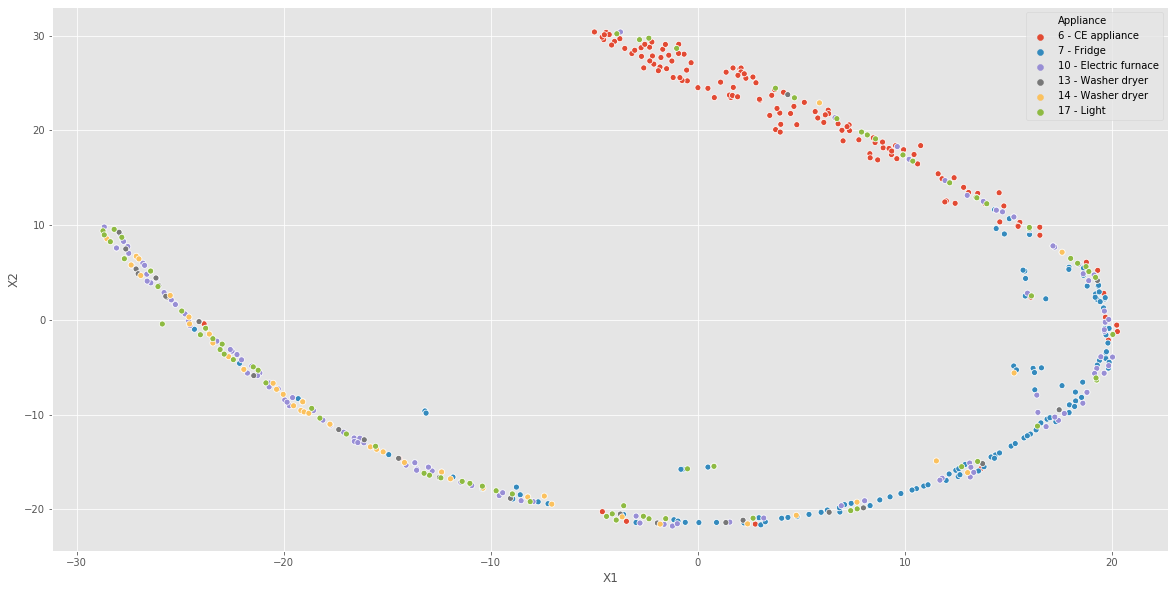

In [50]:
X_projected = TSNE(
    n_components=2,
#     perplexity=50,
#     learning_rate=500,
    random_state = 42
).fit_transform(df_analysis[ useful_columns_rqa ])

df_projected = pd.DataFrame(X_projected, columns=["X1","X2"])
df_projected["Appliance"] = df_analysis["Appliance"].values
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x="X1", y="X2", hue="Appliance", data=df_projected);

**CONCLUSÕES:**

Um dos grandes desafios na elaboração de um classificador baseado em IA é a adoção de uma ferramenta eficiente para a representação dos dados de entrada, de modo que esta lide bem com ruídos, outliers, além de codificar de modo consistente a natureza original do problema, mantendo a distribuição de classes a priori distintas.

No âmbito de classificação de séries temporais para a desagregação de energia (NILM) em baixa-frequência, estas ferramentas se tornam aindam mais importantes, uma vez que apenas a variação temporal e magnitude de consumo energético são as informações disponíveis.

Neste contexto surge o Gráfico de Recorrência (RP), o qual se baseia na transformação da série original em uma representação gráfica das recorrências do sistema dinâmico, permitindo realizar uma inspeção visual das medições. Ainda, a partir de estatístcas de tipologia e textura, é possível avaliar quantitativamente e qualitativamente os gráficos gerados, através dos indicadores de RQA.

Logo, introduzimos neste estudo uma avaliação completa a cerca da utilização dos RPs para os dados da base REDD, no qual foi possível avaliar que a adoção desta ferramenta permite extrairmos informações valiosas a cerca da distribuição do perfil de consumo de cada aparelho doméstico, principalmente dentre o grupo de aparelhos que mais consomem energia.

Portanto, a ferramenta de RP demonstra grande poder de representação de series temporais, na qual os gráficos resultantes conseguem gerar estatísticas suficientemente discrimativas, comportamento este desejável para aplicações no contexto de aprendizado de máquina.